<a href="https://colab.research.google.com/github/Nmg1994/Crop_yield_prediction/blob/main/Crop_yield_prediction_Climate_Change_Scenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary packages

In [1]:
!pip install rasterio
!pip install scikit-learn xgboost lightgbm optuna
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not insta

# Importing necessary libraries/modules

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

# Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preparing dataframes of Canola and Soybeans yields

In [ ]:
yields_all_crops_df = pd.read_csv('/content/drive/My Drive/Crop_yield_prediction_CAR/historical_actual_crop_yield_by_CAR.csv')
yields_two_crops_df = yields_all_crops_df[(yields_all_crops_df['CROP'] == 'canola') | (yields_all_crops_df['CROP'] == 'soybeans')]
yields_two_crops_df_2021 = yields_two_crops_df[['CARUID',	'CROP', 'Y2021']]
yields_two_crops_df_2021_cleaned = yields_two_crops_df_2021[~yields_two_crops_df_2021.isin([-999]).any(axis=1)].reset_index(drop=True)

In [ ]:
CAR_id  = yields_two_crops_df_2021_cleaned['CARUID'].unique()
crops = ['Canola', 'Soybeans']
years = ['2021']
New_df = pd.DataFrame()

columns_title = ['CARUID']
for crop in crops:
  for year in years:
    columns_title.append(f'{crop}_{year}')

New_df = pd.DataFrame(columns=columns_title)
New_df['CARUID'] = CAR_id

for id in tqdm(CAR_id , desc= 'Progress'):
  # Canola
  if not yields_two_crops_df_2021_cleaned[(yields_two_crops_df_2021_cleaned['CARUID'] == id) & (yields_two_crops_df_2021_cleaned['CROP'] == 'canola')].empty:
    New_df.loc[New_df['CARUID'] == id, 'Canola_2021'] = yields_two_crops_df_2021_cleaned[(yields_two_crops_df_2021_cleaned['CARUID'] == id) & (yields_two_crops_df_2021_cleaned['CROP'] == 'canola')]['Y2021'].values[0]
  else:
    New_df.loc[New_df['CARUID'] == id, 'Canola_2021'] = 0
  #Soybeans
  if not yields_two_crops_df_2021_cleaned[(yields_two_crops_df_2021_cleaned['CARUID'] == id) & (yields_two_crops_df_2021_cleaned['CROP'] == 'soybeans')].empty:
    New_df.loc[New_df['CARUID'] == id, 'Soybeans_2021'] = yields_two_crops_df_2021_cleaned[(yields_two_crops_df_2021_cleaned['CARUID'] == id) & (yields_two_crops_df_2021_cleaned['CROP'] == 'soybeans')]['Y2021'].values[0]
  else:
    New_df.loc[New_df['CARUID'] == id, 'Soybeans_2021'] = 0

New_df.to_csv('/content/drive/My Drive/Crop_yield_prediction_CAR/crop_yields_two_crops.csv', index=False)

Progress: 100%|██████████| 60/60 [00:00<00:00, 71.13it/s]


# Preparing the variables before feeding them into the models

In [ ]:
# Importing the dataframe including the soil characteristics and yields' values
Soil_and_Bees_2021_old_order = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_2021.xlsx')
Soil_and_Bees_2021_old_order.drop(columns = ['OBJECTID *', 'Shape *',	'New_ID *','Shape_Length', 'Shape_Area', 'OBJECTID', 'CCSUID', 'CCSNAME', 'SRUNOM','Shape_Length.1', 'Shape_Area.1'], axis=1, inplace=True)

# New column order
new_order = ['New_ID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
       'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
       'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N', 'VALUE']

# Reordering the columns
Soil_and_Bees_2021 = Soil_and_Bees_2021_old_order.reindex(columns=new_order)

CAR_CSS = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/CAR_CSS.xlsx')
CAR_CSS.drop_duplicates(subset=['New_ID'], inplace=True)
Soil_and_Bees_CCS_CAR = pd.merge(Soil_and_Bees_2021, CAR_CSS, on='New_ID', how='left')

In [ ]:
# Filling the CCS lacking EVI and NDVI based on their minimum and maximum values
def fill_na(row):
  if pd.isna(row['MIN']):
    return (row['MAX'])
  elif pd.isna(row['MAX']):
    return (row['MIN'])
  elif pd.isna(row['MEAN']):
    return (row['MIN'] + row['MAX']) / 2
  else:
    return row['MEAN']

Soil_and_Bees_CCS_CAR_copy = Soil_and_Bees_CCS_CAR.copy()

Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

for m in tqdm(range(len(Months)), desc="Processing"):
  EVI = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/EVI_{Months[m]}.xlsx')
  NDVI = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/NDVI_{Months[m]}.xlsx')
  Air_min = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_min_{Months[m]}.xlsx')
  Air_max = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_max_{Months[m]}.xlsx')
  Air_avg = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Air_avg_{Months[m]}.xlsx')
  Precip = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Precip_{Months[m]}.xlsx')

  # Applying the fill_na function on EVI and NDVI
  EVI[f'MEAN_EVI_{Months[m]}'] = EVI.apply(fill_na, axis=1)
  NDVI[f'MEAN_NDVI_{Months[m]}'] = NDVI.apply(fill_na, axis=1)

  Air_min[f'MEAN_Air_min_{Months[m]}'] = Air_min['MEAN']
  Air_max[f'MEAN_Air_max_{Months[m]}'] = Air_max['MEAN']
  Air_avg[f'MEAN_Air_avg_{Months[m]}'] = Air_avg['MEAN']
  Precip[f'MEAN_Precip_{Months[m]}'] = Precip['MEAN']

  EVI = EVI.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  NDVI = NDVI.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_min = Air_min.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max = Air_max.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_avg = Air_avg.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip = Precip.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  # Performing a left join
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, EVI, on='New_ID', how='left')
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, NDVI, on='New_ID', how='left')
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, Air_min, on='New_ID', how='left')
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, Air_max, on='New_ID', how='left')
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, Air_avg, on='New_ID', how='left')
  Soil_and_Bees_CCS_CAR_copy = pd.merge(Soil_and_Bees_CCS_CAR_copy, Precip, on='New_ID', how='left')

Soil_and_Bees_CCS_CAR_copy.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_CCS_CAR_2021.xlsx', index=False)

Processing: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


In [ ]:
Yields = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Yields.xlsx')
Soil_and_Bees_CCS_CAR_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_CCS_CAR_2021.xlsx')

Yields_2021 = Yields[['CARUID', 'Canola_2021', 'Soybeans_2021']]

Soil_and_Bees_Yields_2021= pd.merge(Soil_and_Bees_CCS_CAR_2021, Yields_2021, on='CARUID', how='left')

# Removing CAR with zero yields for both crops; if there would be a CAR with the yields zero for both crops, it will be removed from further investigation
def removing_CAR_with_zero_yields_for_both_crops(DF):
  df = DF[(DF['Canola_2021'] != 0) | (DF['Soybeans_2021'] != 0)].reset_index(drop=True)
  return df

Soil_and_Bees_Yields_2021_prepared = removing_CAR_with_zero_yields_for_both_crops(Soil_and_Bees_Yields_2021)
Soil_and_Bees_Yields_2021_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_Yields_2021_prepared.xlsx', index=False)

In [ ]:
Soil_and_Bees_Yields_2021_prepared = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_Yields_2021_prepared.xlsx')
Soil_and_Bees_Yields_2021_prepared.drop(columns = ['New_ID'], axis=1, inplace=True)

# Define the aggregation functions
agg_funcs = {
    'MEAN_BASES_N': 'mean',
    'MEAN_BD_N': 'mean',
    'MEAN_CEC_N': 'mean',
    'MEAN_KP0_N': 'mean',
    'MEAN_KP1500_N': 'mean',
    'MEAN_KP33_N': 'mean',
    'MEAN_KSAT_N': 'mean',
    'MEAN_ORGCARB_N': 'mean',
    'MEAN_PHCA_N': 'mean',
    'MEAN_TCLAY_N': 'mean',
    'MEAN_TSAND_N': 'mean',
    'MEAN_TSILT_N': 'mean',
    'VALUE': 'sum',
    'MEAN_EVI_May': 'mean',
    'MEAN_NDVI_May': 'mean',
    'MEAN_Air_min_May': 'mean',
    'MEAN_Air_max_May': 'mean',
    'MEAN_Air_avg_May': 'mean',
    'MEAN_Precip_May': 'mean',
    'MEAN_EVI_Jun': 'mean',
    'MEAN_NDVI_Jun': 'mean',
    'MEAN_Air_min_Jun': 'mean',
    'MEAN_Air_max_Jun': 'mean',
    'MEAN_Air_avg_Jun': 'mean',
    'MEAN_Precip_Jun': 'mean',
    'MEAN_EVI_Jul': 'mean',
    'MEAN_NDVI_Jul': 'mean',
    'MEAN_Air_min_Jul': 'mean',
    'MEAN_Air_max_Jul': 'mean',
    'MEAN_Air_avg_Jul': 'mean',
    'MEAN_Precip_Jul': 'mean',
    'MEAN_EVI_Aug': 'mean',
    'MEAN_NDVI_Aug': 'mean',
    'MEAN_Air_min_Aug': 'mean',
    'MEAN_Air_max_Aug': 'mean',
    'MEAN_Air_avg_Aug': 'mean',
    'MEAN_Precip_Aug': 'mean',
    'MEAN_EVI_Sep': 'mean',
    'MEAN_NDVI_Sep': 'mean',
    'MEAN_Air_min_Sep': 'mean',
    'MEAN_Air_max_Sep': 'mean',
    'MEAN_Air_avg_Sep': 'mean',
    'MEAN_Precip_Sep': 'mean',
    'Canola_2021': 'sum',
    'Soybeans_2021': 'sum'
}

# Group by the column CARUID and aggregate
dissolved_Soil_and_Bees_Yields_2021_prepared = Soil_and_Bees_Yields_2021_prepared.groupby('CARUID').agg(agg_funcs).reset_index()
dissolved_Soil_and_Bees_Yields_2021_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/dissolved_Soil_and_Bees_Yields_2021_prepared.xlsx', index=False)

In [ ]:
def preprocessing_function(df):
  CAR_ID = df['CARUID'].drop_duplicates().to_numpy()
  Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

  Constant_variables = df[['CARUID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
                            'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
                            'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N', 'VALUE',
                            'Canola_2021', 'Soybeans_2021']].copy()

  # List of new column names
  new_column_names = ['CARUID', 'Base saturation', 'Bulk density', 'Cation exchange capacity', 'Water retention KP0',
                      'Water retention KP1500', 'Water retention KP33', 'Saturated hydraulic conductivity', 'Soil organic carbon',
                      'PH', 'Clay', 'Sand', 'Silt', 'Honeybee colonies', 'Canola', 'Soybeans']

  # Assigning new column names
  Constant_variables.columns = new_column_names

  df_prepared = pd.DataFrame()

  for m in tqdm(range(len(Months)), desc='Month processing'):
    for id_index in CAR_ID:
      temp = Constant_variables[Constant_variables['CARUID'] == id_index].copy()
      temp['Months'] = m + 5
      temp['EVI'] = df.loc[df['CARUID'] == id_index, f'MEAN_EVI_{Months[m]}'].values[0]
      temp['NDVI'] = df.loc[df['CARUID'] == id_index, f'MEAN_NDVI_{Months[m]}'].values[0]
      temp['Minimum temperature'] = df.loc[df['CARUID'] == id_index, f'MEAN_Air_min_{Months[m]}'].values[0]
      temp['Maximum temperature'] = df.loc[df['CARUID'] == id_index, f'MEAN_Air_max_{Months[m]}'].values[0]
      temp['Mean temperature'] = df.loc[df['CARUID'] == id_index, f'MEAN_Air_avg_{Months[m]}'].values[0]
      temp['Precipitation'] = df.loc[df['CARUID'] == id_index, f'MEAN_Precip_{Months[m]}'].values[0]

      df_prepared = pd.concat([df_prepared, temp], axis=0, ignore_index=True)

  df_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx', index=False)
  pd.DataFrame(CAR_ID, columns=['CARUID']).to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/CAR_ID.xlsx', index=False)

dissolved_Soil_and_Bees_Yields_2021_prepared = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/dissolved_Soil_and_Bees_Yields_2021_prepared.xlsx')
preprocessing_function(dissolved_Soil_and_Bees_Yields_2021_prepared)


Month processing: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


# Pearson and Spearman correlation assumption checks

In [17]:
All_variables_prepared_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx')
var_2021_Canola = All_variables_prepared_2021.drop(columns = ['CARUID', 'Soybeans','Months'], axis=1)
var_2021_Soybeans = All_variables_prepared_2021.drop(columns = ['CARUID', 'Canola','Months'], axis=1)
var_2021 = All_variables_prepared_2021.drop(columns = ['CARUID', 'Canola','Soybeans', 'Months'], axis=1)

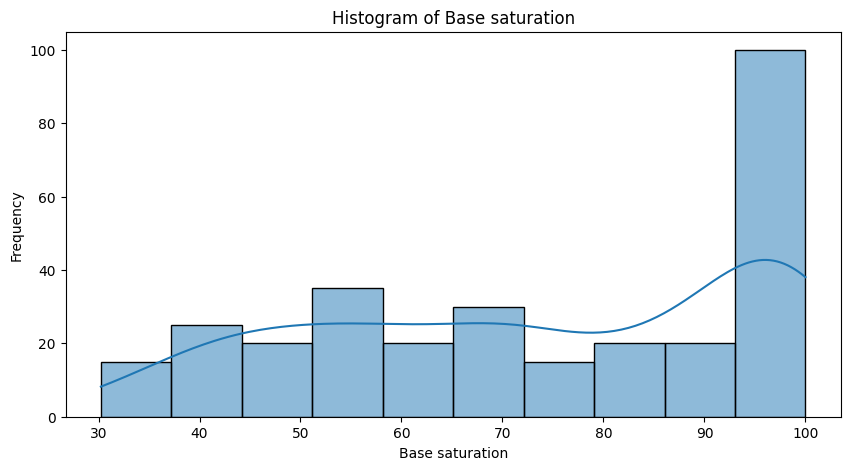

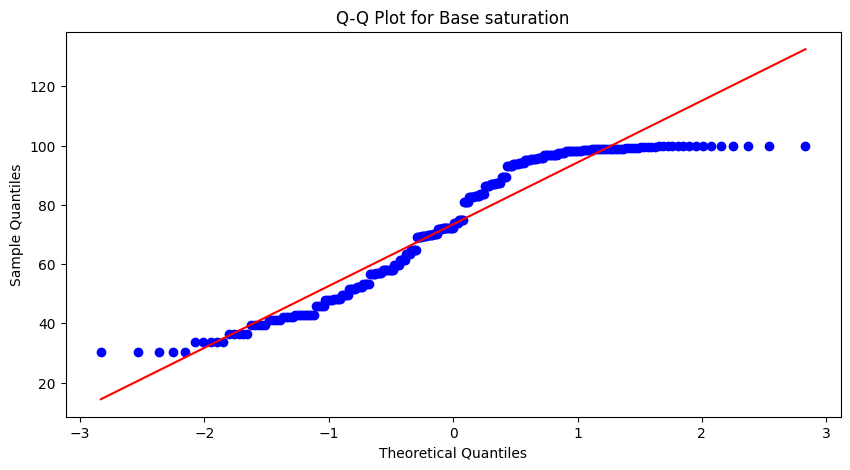

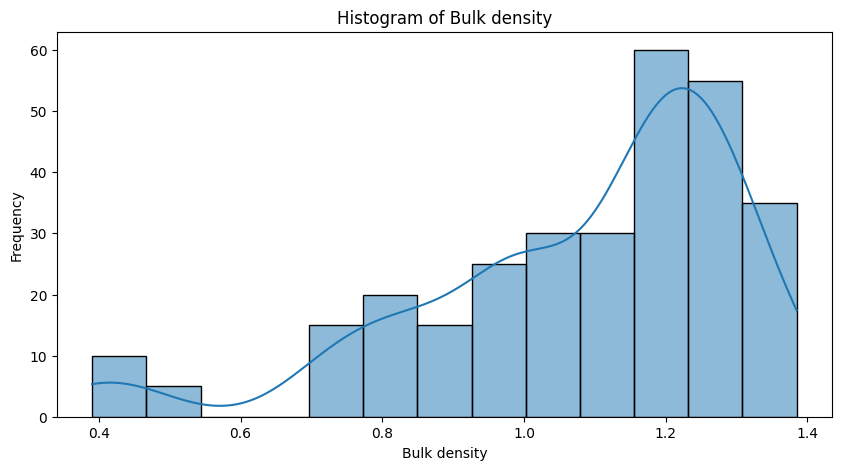

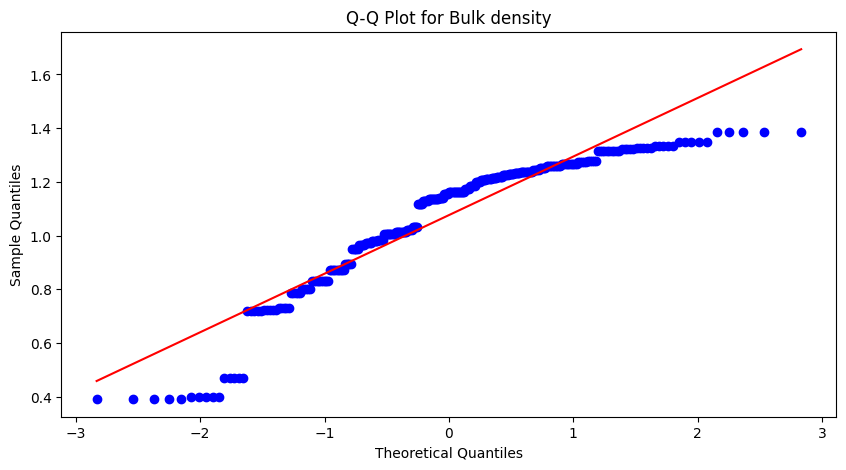

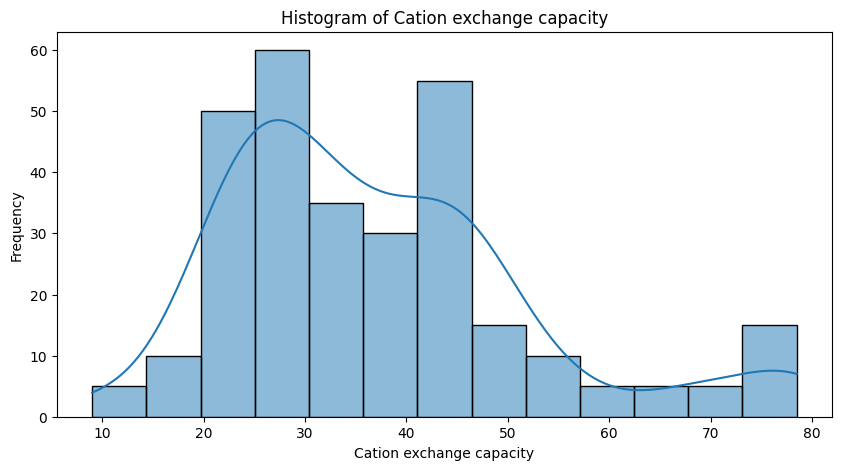

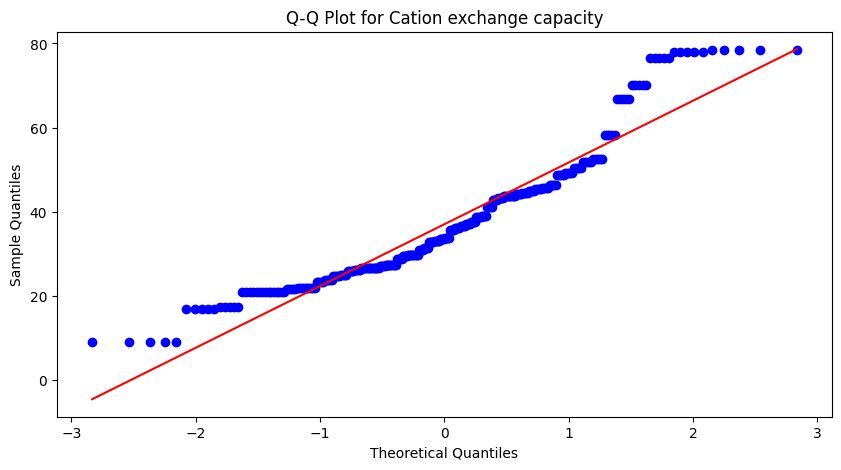

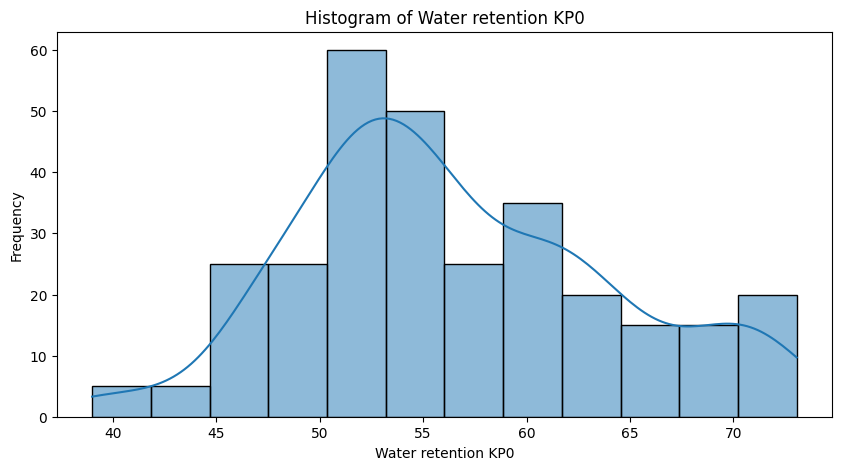

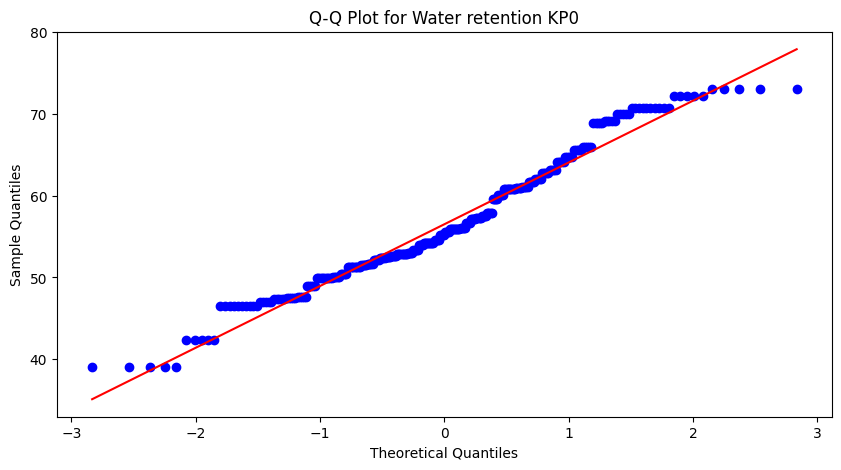

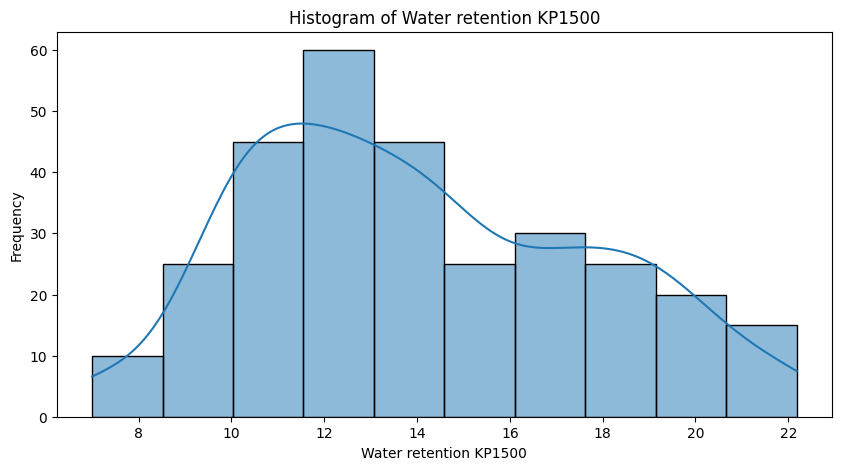

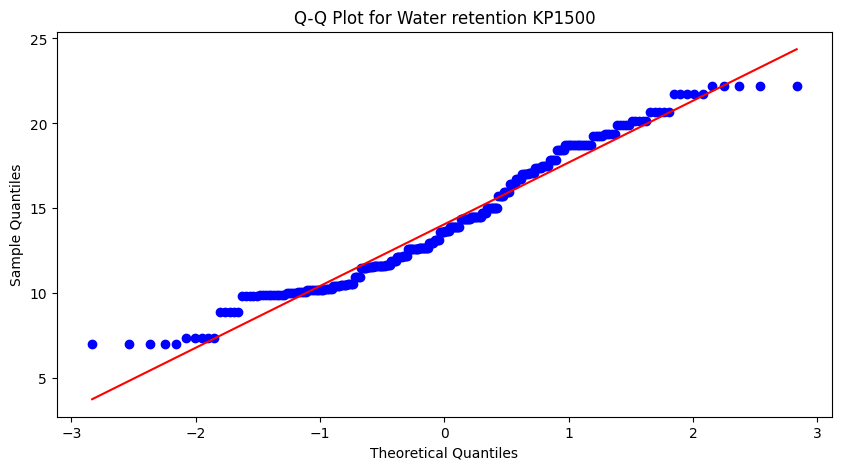

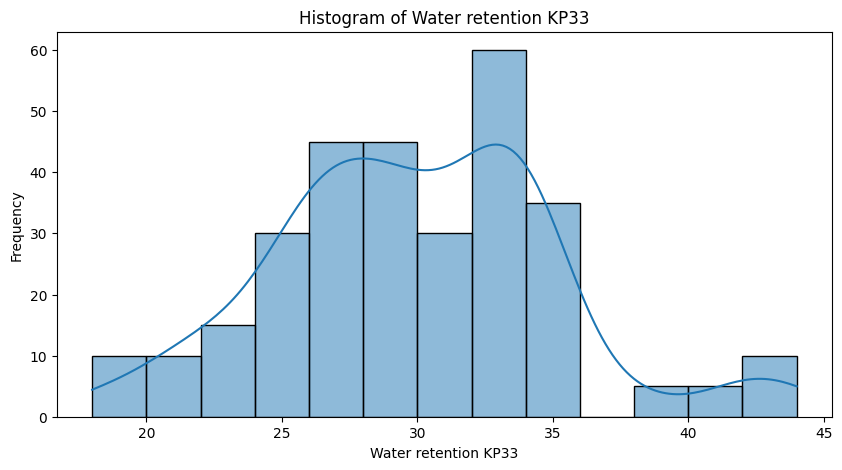

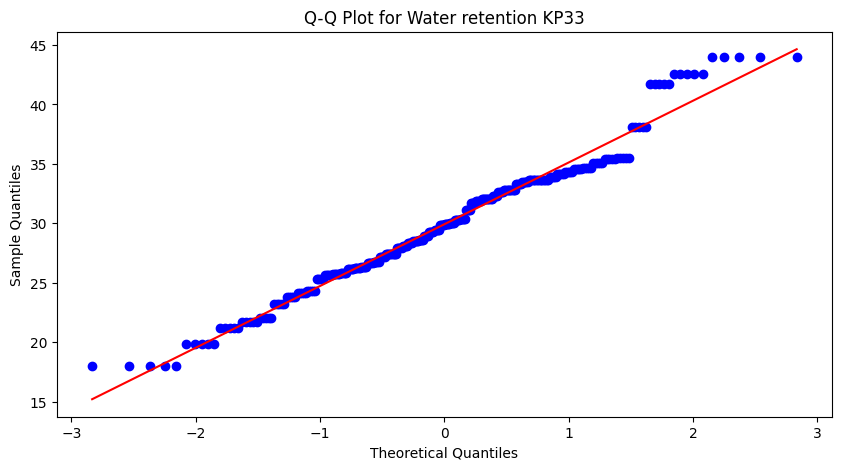

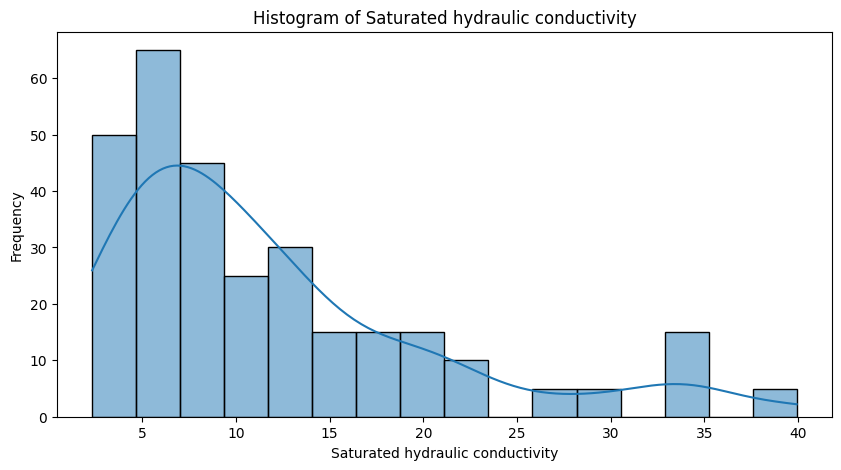

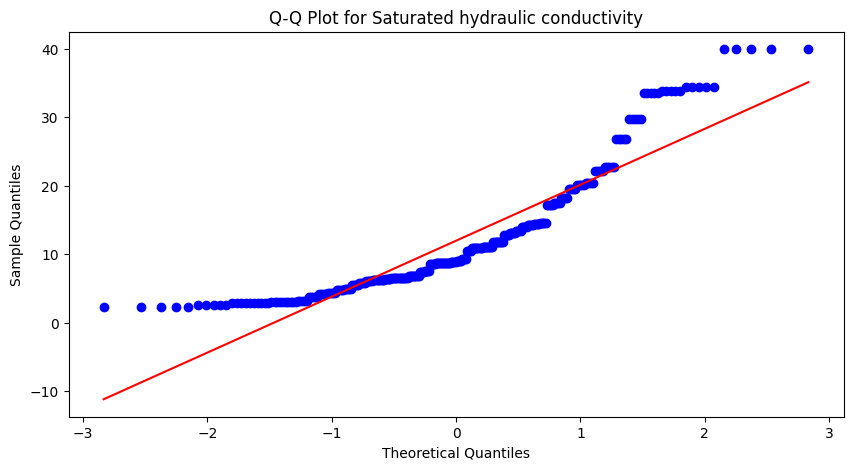

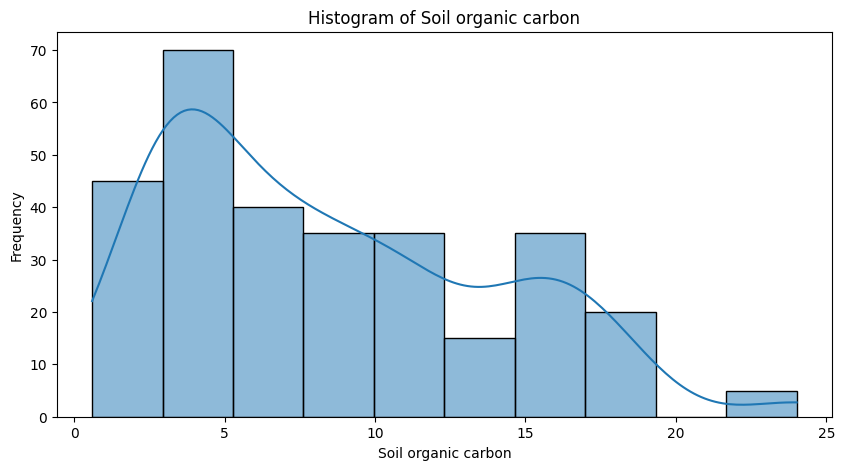

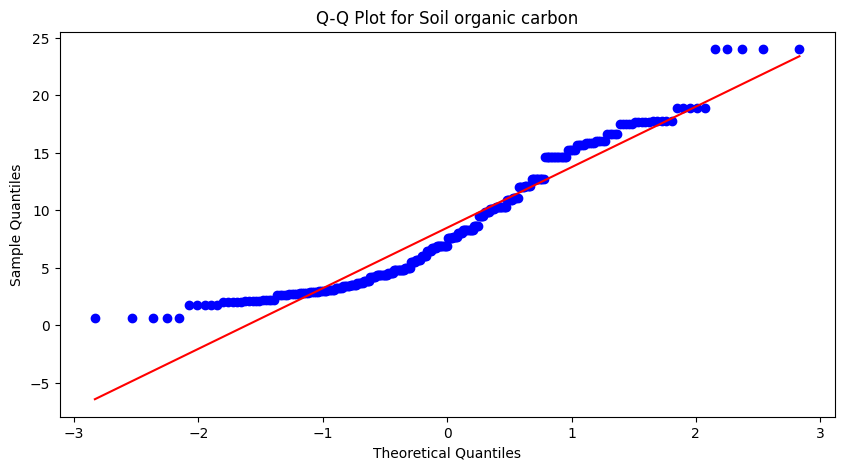

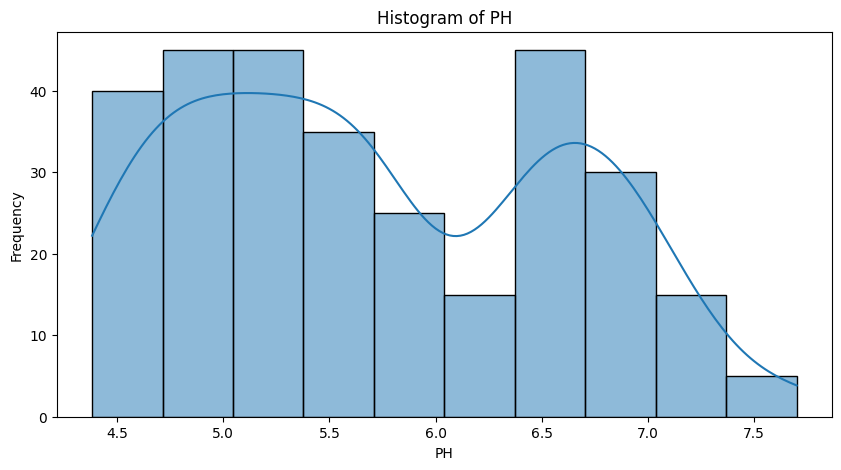

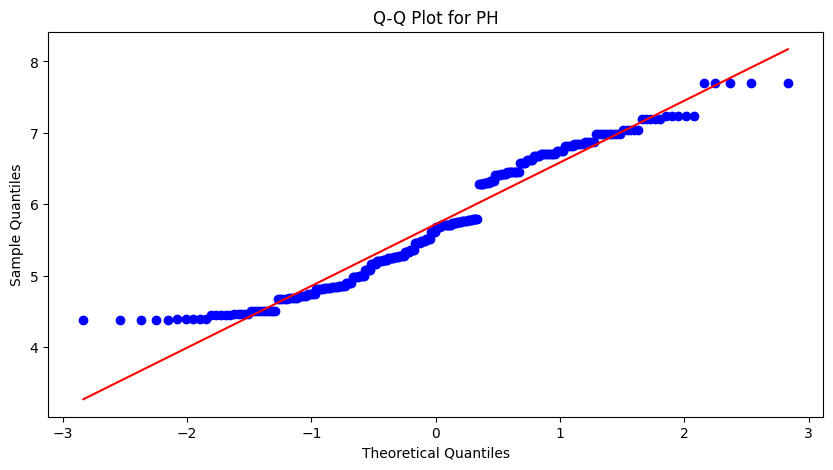

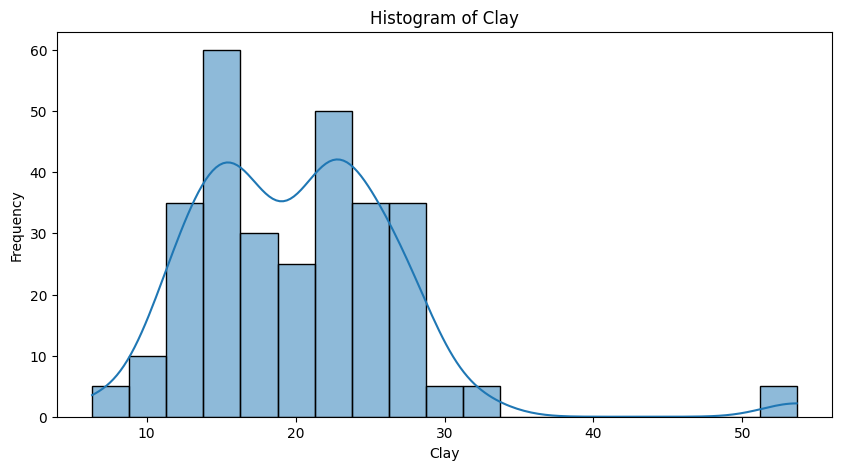

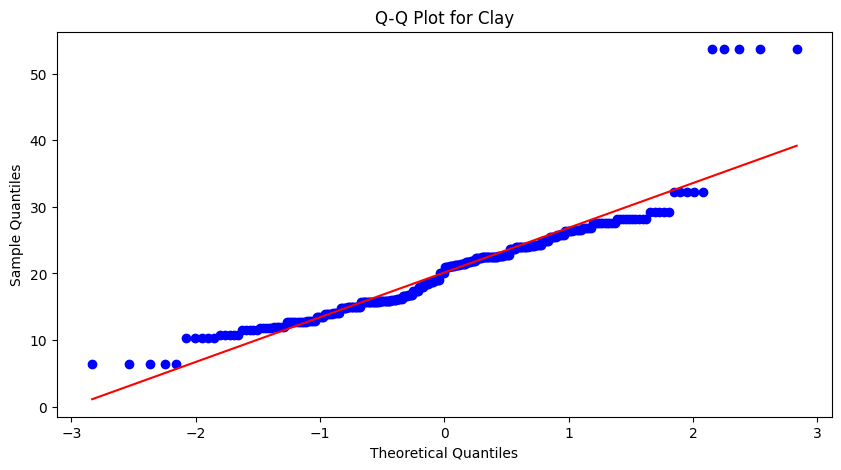

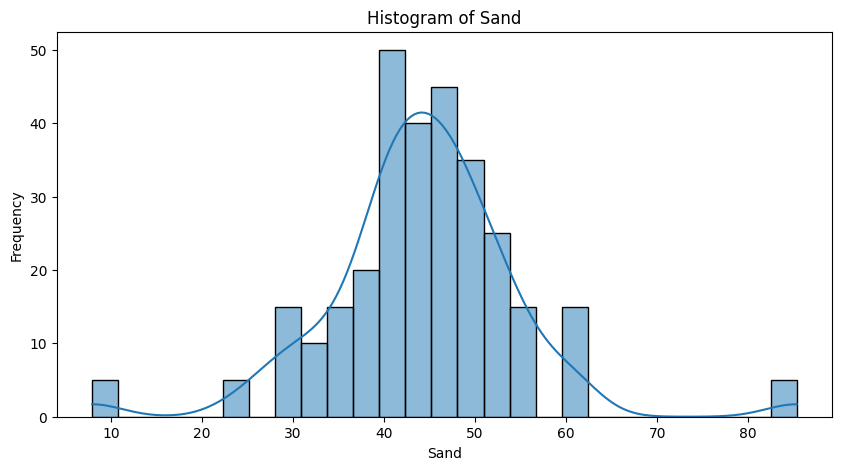

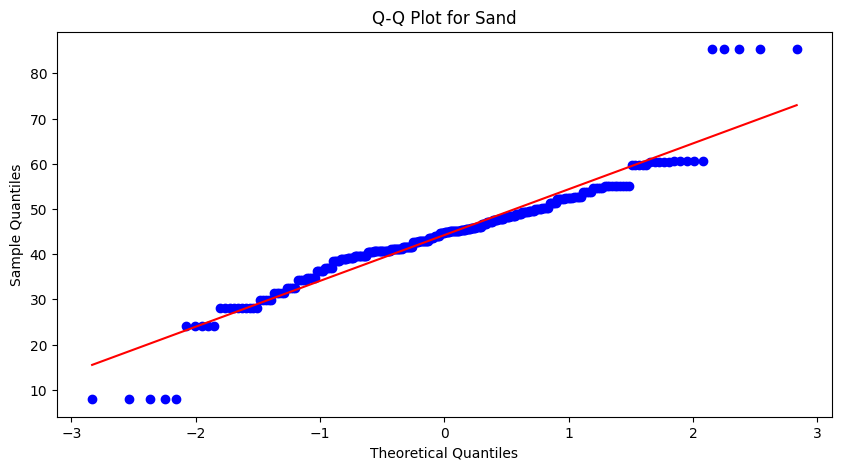

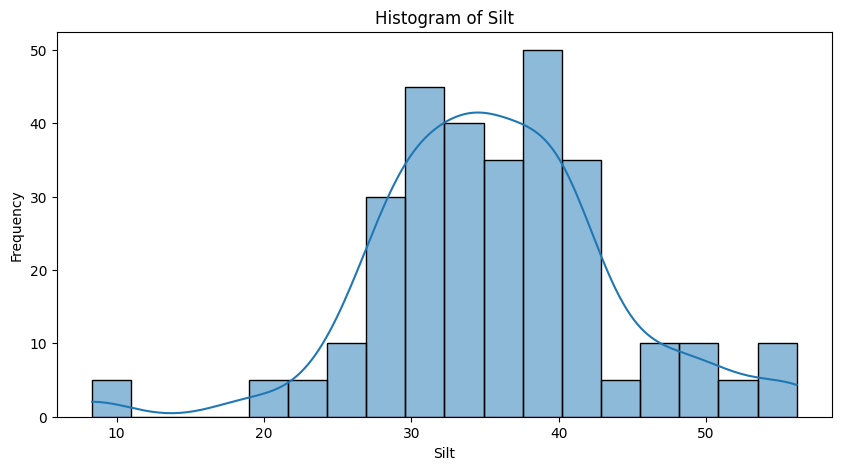

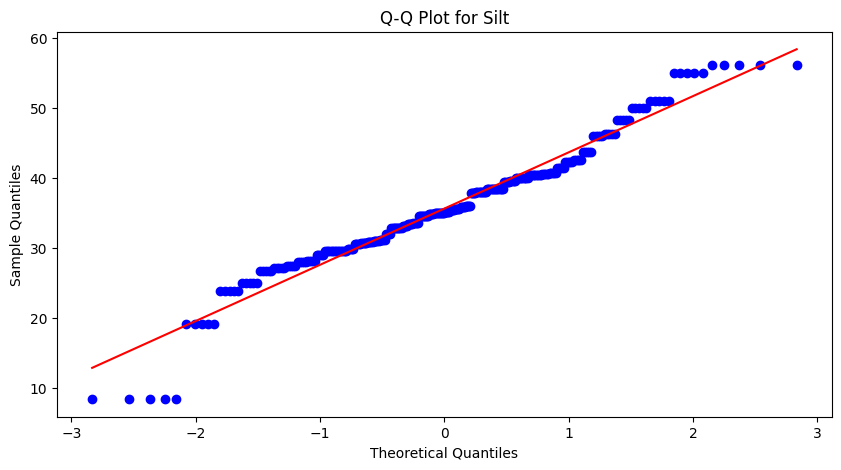

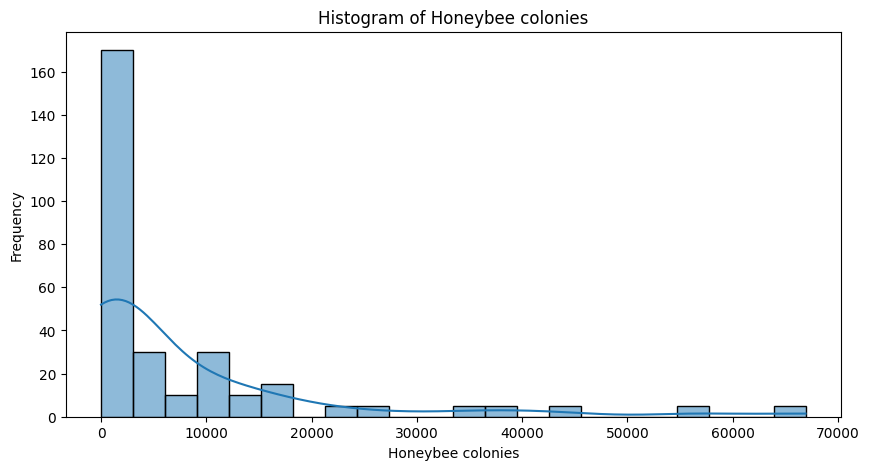

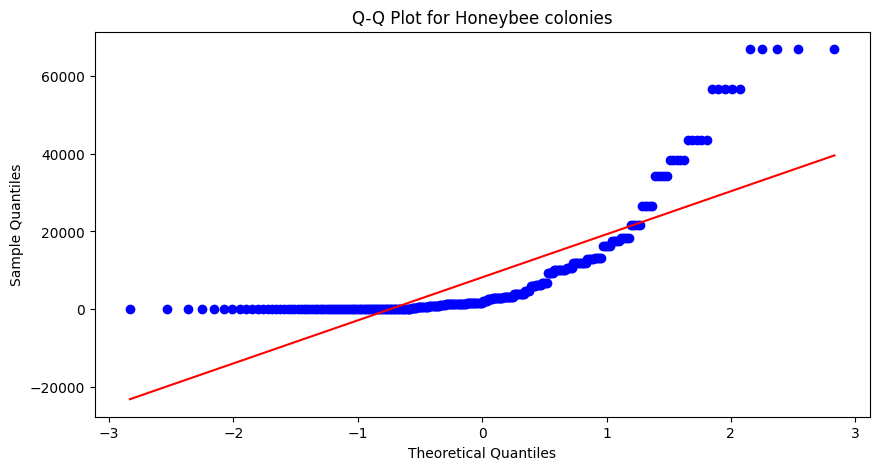

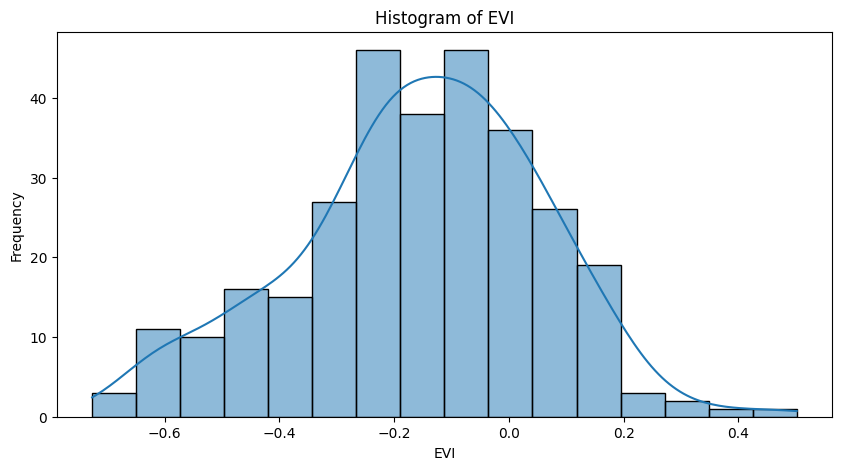

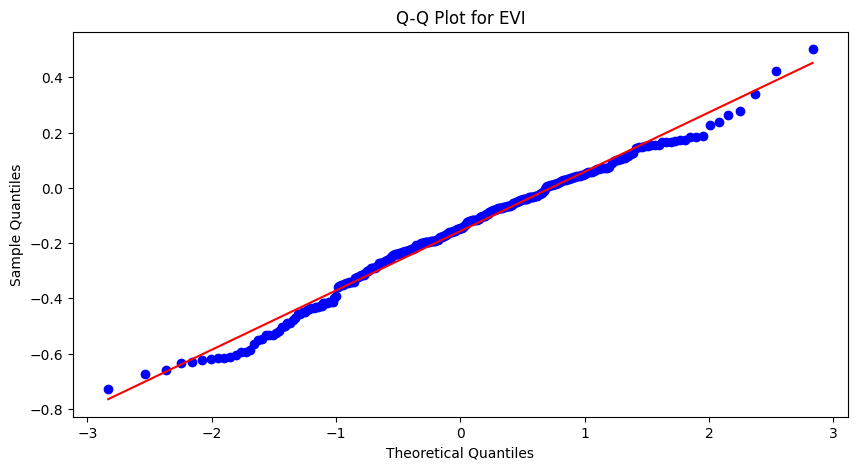

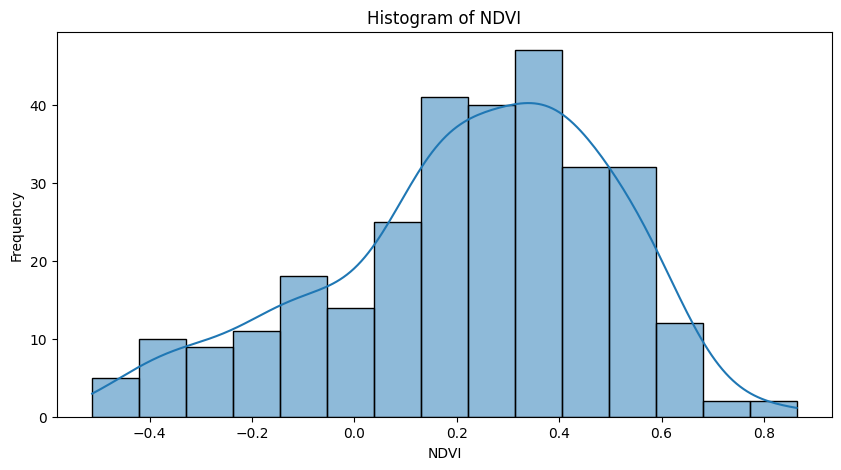

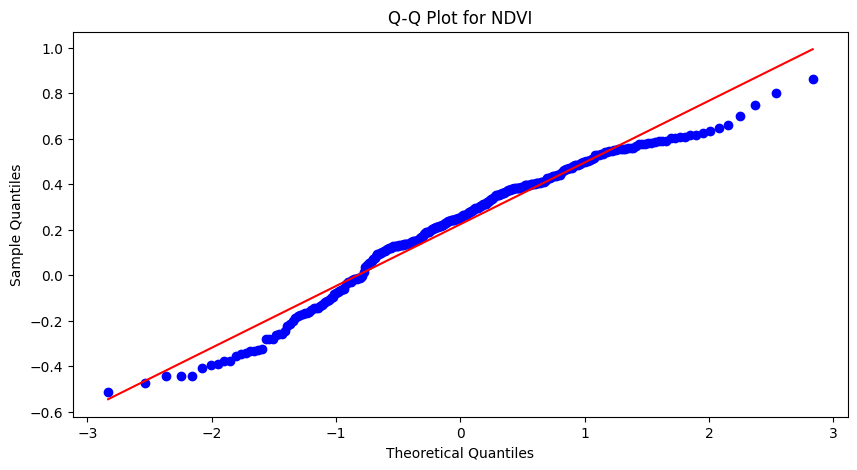

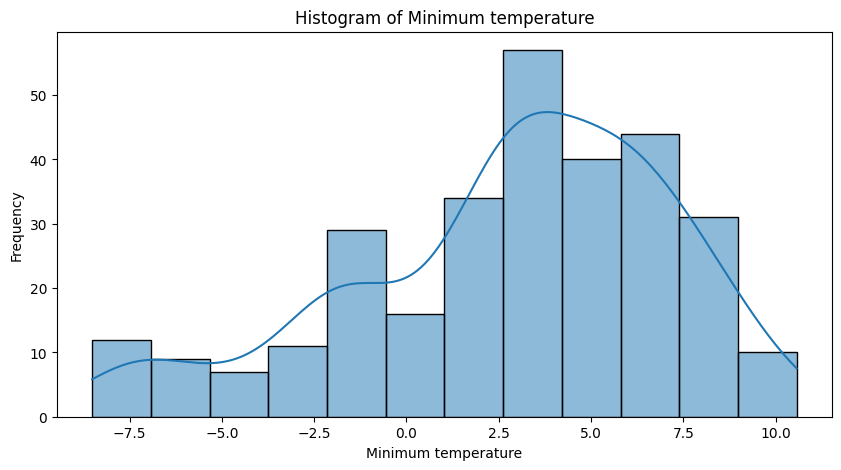

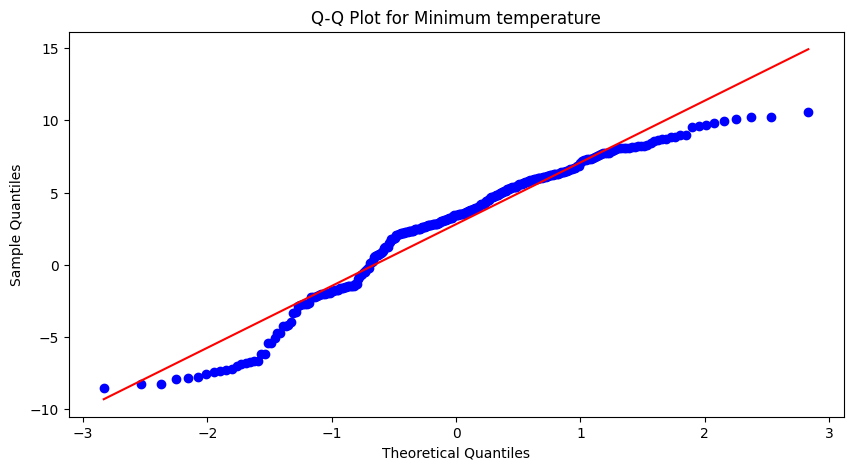

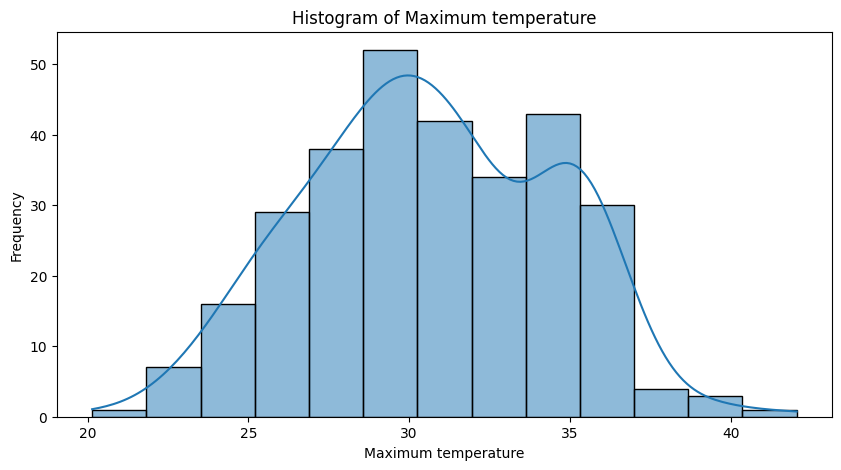

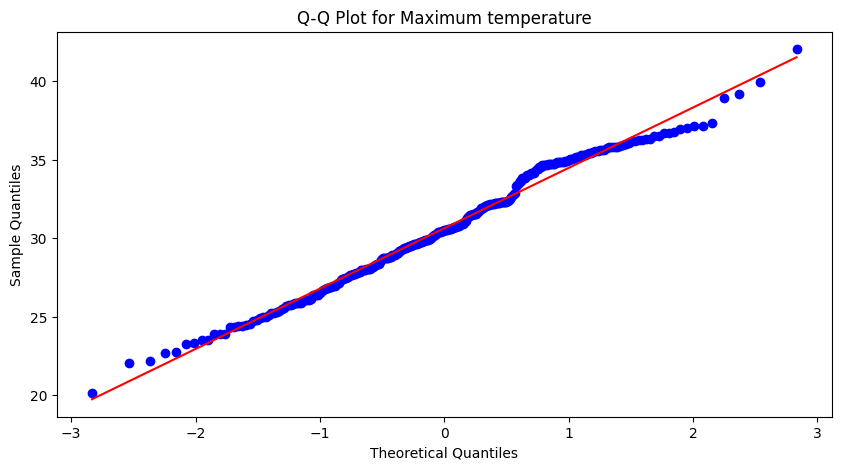

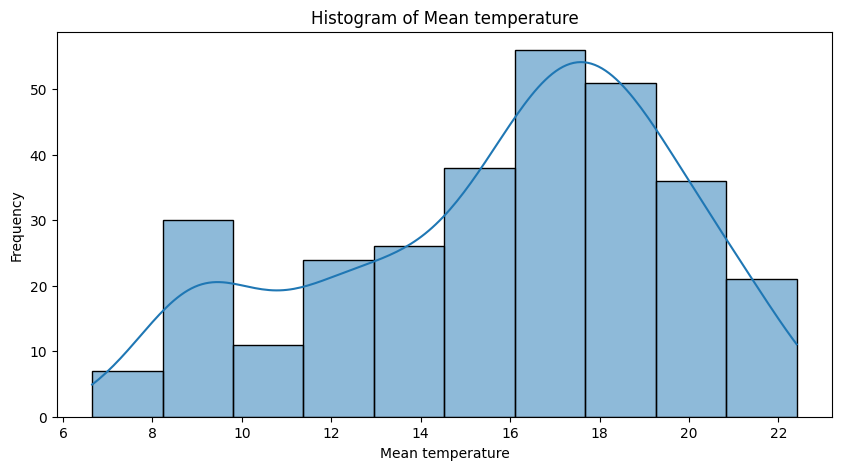

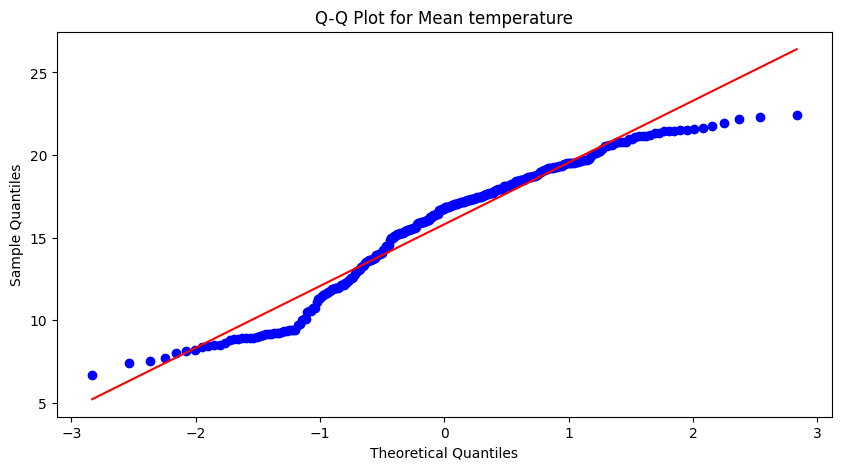

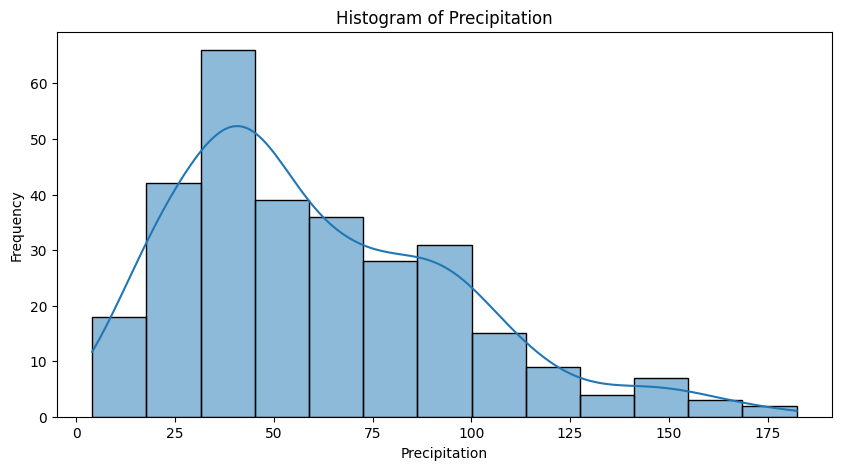

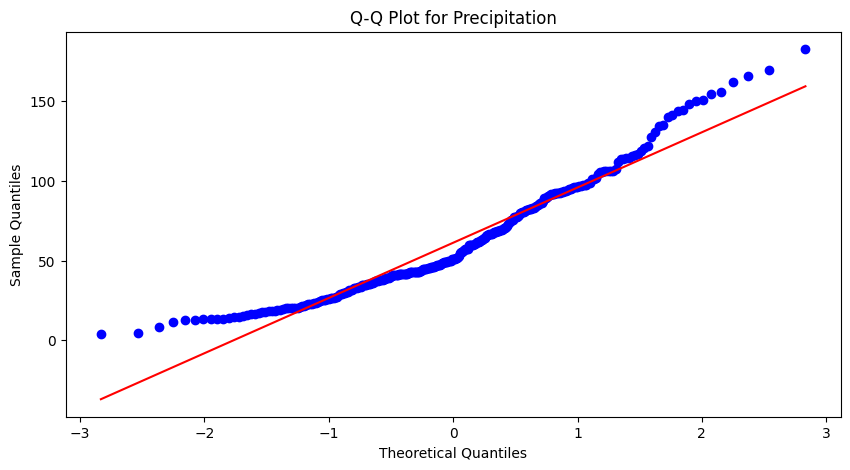

In [16]:
# List of columns for the variables
features = ['Base saturation', 'Bulk density', 'Cation exchange capacity',
            'Water retention KP0', 'Water retention KP1500', 'Water retention KP33',
            'Saturated hydraulic conductivity', 'Soil organic carbon', 'PH', 'Clay',
            'Sand', 'Silt', 'Honeybee colonies', 'EVI', 'NDVI',
            'Minimum temperature', 'Maximum temperature', 'Mean temperature',
            'Precipitation']

# Plotting histograms and Q-Q plots for each variable
for feature in features:
  # Histogram with KDE
  plt.figure(figsize=(10, 5))
  sns.histplot(var_2021[feature], kde=True)
  plt.title(f"Histogram of {feature}")
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.show()

  # Q-Q Plot
  plt.figure(figsize=(10, 5))
  stats.probplot(var_2021[feature], dist="norm", plot=plt)
  plt.title(f"Q-Q Plot for {feature}")
  plt.xlabel("Theoretical Quantiles")
  plt.ylabel("Sample Quantiles")
  plt.show()

In [19]:
# Shapiro-Wilk test for normality investigation
for feature in features:
  stat, p_value = stats.shapiro(var_2021[feature])
  print(f"Shapiro-Wilk test for {feature}: p-value = {p_value}")

# All variables together
stat_x, p_value_x = stats.shapiro(var_2021[['Base saturation', 'Bulk density', 'Cation exchange capacity',
       'Water retention KP0', 'Water retention KP1500', 'Water retention KP33',
       'Saturated hydraulic conductivity', 'Soil organic carbon', 'PH', 'Clay',
       'Sand', 'Silt', 'Honeybee colonies', 'EVI', 'NDVI',
       'Minimum temperature', 'Maximum temperature', 'Mean temperature',
       'Precipitation']])
print(f"Shapiro-Wilk test for x: p-value = {p_value_x}")

# Canola
stat_canola_y, p_value_canola_y = stats.shapiro(var_2021_Canola['Canola'])
print(f"Shapiro-Wilk test for y canola: p-value = {p_value_canola_y}")

# Soybeans
stat_soybeans_y, p_value_soybeans_y = stats.shapiro(var_2021_Soybeans['Soybeans'])
print(f"Shapiro-Wilk test for y soybeans: p-value = {p_value_soybeans_y}")

Shapiro-Wilk test for Base saturation: p-value = 1.2675234565856493e-12
Shapiro-Wilk test for Bulk density: p-value = 1.6898861302707168e-14
Shapiro-Wilk test for Cation exchange capacity: p-value = 8.440069268858671e-12
Shapiro-Wilk test for Water retention KP0: p-value = 6.7925713545657045e-06
Shapiro-Wilk test for Water retention KP1500: p-value = 7.055670068127568e-07
Shapiro-Wilk test for Water retention KP33: p-value = 9.417423003912533e-05
Shapiro-Wilk test for Saturated hydraulic conductivity: p-value = 1.376330863325567e-16
Shapiro-Wilk test for Soil organic carbon: p-value = 4.8022917393254584e-11
Shapiro-Wilk test for PH: p-value = 3.909711944132047e-09
Shapiro-Wilk test for Clay: p-value = 1.1918555507397517e-14
Shapiro-Wilk test for Sand: p-value = 8.255450107942838e-12
Shapiro-Wilk test for Silt: p-value = 6.44706856379883e-07
Shapiro-Wilk test for Honeybee colonies: p-value = 5.656310755458696e-25
Shapiro-Wilk test for EVI: p-value = 0.01646672772896693
Shapiro-Wilk test

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5700.
  res = hypotest_fun_out(*samples, **kwds)


# Spearman correlation analyses

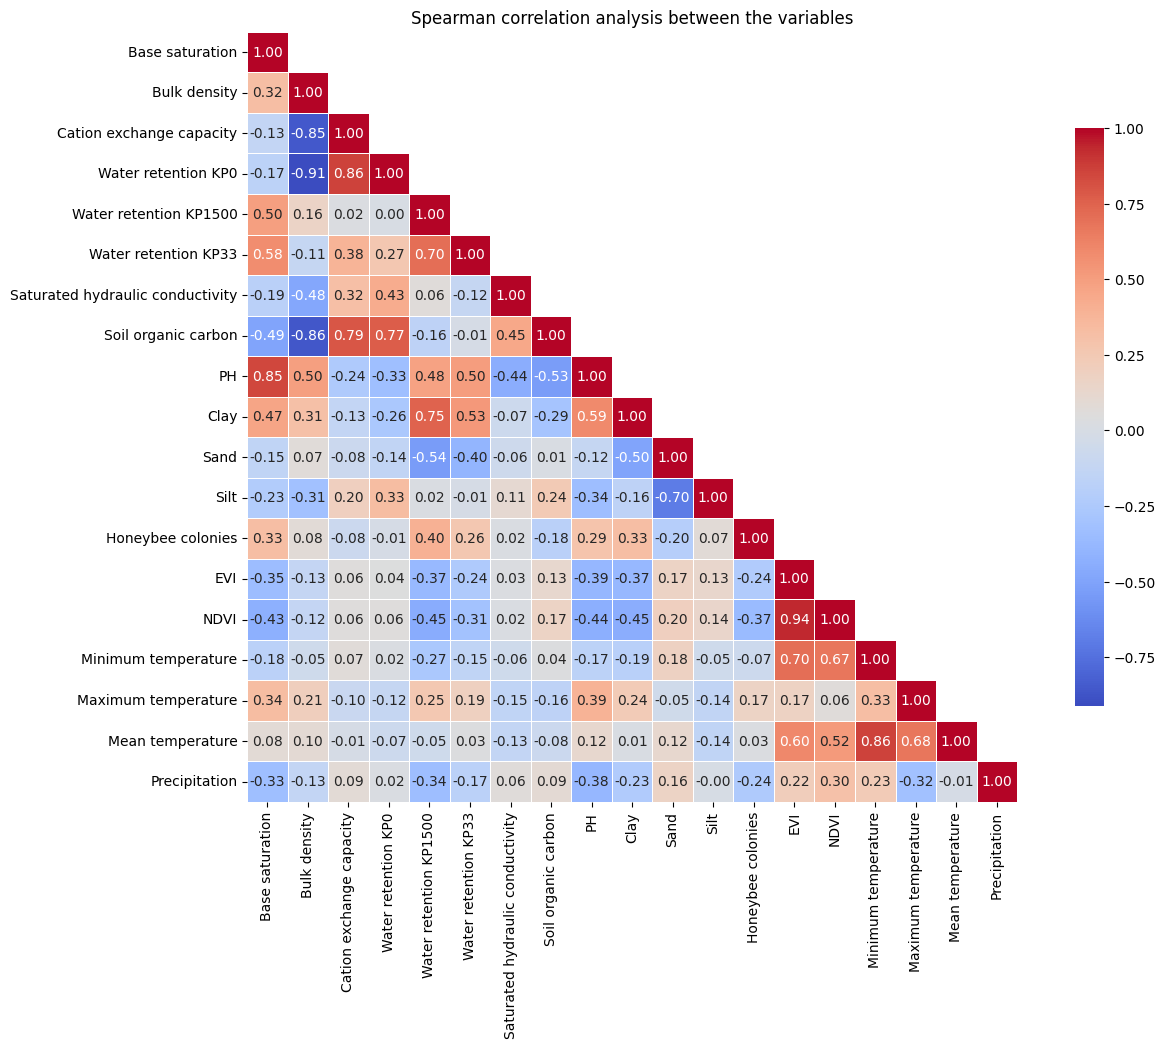

In [ ]:
All_variables_prepared_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx')
var_2021 = All_variables_prepared_2021.drop(columns = ['CARUID','Canola', 'Soybeans','Months'], axis=1)

# Calculating the Spearman correlation matrix
corr_matrix = var_2021.corr(method='spearman')

# Masking the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Setting up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plotting the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title('Spearman correlation analysis between the variables')
plt.show()

In [ ]:
# Calculating VIF and Tolerance
def calculate_vif(df):
  # Adding a constant column for the intercept
  df_with_constant = sm.add_constant(df)

  # Calculating VIF for each feature
  vif_data = pd.DataFrame()
  vif_data['Feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i+1) for i in range(len(df.columns))]
  vif_data['Tolerance'] = 1 / vif_data['VIF']

  return vif_data

# Using the function to calculate VIF and Tolerance
vif_df = calculate_vif(var_2021)

# Formatting VIF and Tolerance values for better readability
vif_df['VIF'] = vif_df['VIF'].map('{:.2f}'.format)
vif_df['Tolerance'] = vif_df['Tolerance'].map('{:.2f}'.format)

print(vif_df)

                             Feature                  VIF Tolerance
0                    Base saturation                10.55      0.09
1                       Bulk density                19.51      0.05
2           Cation exchange capacity                17.01      0.06
3                Water retention KP0                10.20      0.10
4             Water retention KP1500                 7.29      0.14
5               Water retention KP33                 6.29      0.16
6   Saturated hydraulic conductivity                 3.84      0.26
7                Soil organic carbon                 8.25      0.12
8                                 PH                13.79      0.07
9                               Clay  4503599627370496.00      0.00
10                              Sand  9007199254740992.00      0.00
11                              Silt  4503599627370496.00      0.00
12                 Honeybee colonies                 2.00      0.50
13                               EVI            

# Climate change scenarios data preparation before the interpolation in ArcGIS Pro

In [ ]:
for g in tqdm(range(1,7), desc='Progress: '):
  T_avg = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tg_mean_{g}.csv')
  T_max = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tx_mean_{g}.csv')
  T_min = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/tn_mean_{g}.csv')
  Prec = pd.read_csv(f'/content/drive/My Drive/Climate_change_scenarios_Canada/prcptot_{g}.csv')

  T_avg_df = T_avg[['time','lat','lon', 'ssp126_tg_mean_p50', 'ssp245_tg_mean_p50', 'ssp585_tg_mean_p50']]
  T_max_df = T_max[['time','lat','lon', 'ssp126_tx_mean_p50', 'ssp245_tx_mean_p50', 'ssp585_tx_mean_p50']]
  T_min_df = T_min[['time','lat','lon', 'ssp126_tn_mean_p50', 'ssp245_tn_mean_p50', 'ssp585_tn_mean_p50']]
  Prec_df = Prec[['time','lat','lon', 'ssp126_prcptot_p50', 'ssp245_prcptot_p50', 'ssp585_prcptot_p50']]

  T_avg_df_2026 = T_avg_df[T_avg_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  T_max_df_2026 = T_max_df[T_max_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  T_min_df_2026 = T_min_df[T_min_df['time'].str.contains('2026', na=False)].reset_index(drop=True)
  Prec_df_2026 = Prec_df[Prec_df['time'].str.contains('2026', na=False)].reset_index(drop=True)

  Coordinates = Prec_df_2026[['lat','lon']].drop_duplicates(subset=['lat', 'lon']).reset_index(drop=True)

  DF_2026 = pd.DataFrame()

  for ind in range(len(Coordinates)):
    latitude = Coordinates['lat'][ind]
    longitude = Coordinates['lon'][ind]

    Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']
    scenarios = ['126', '245', '585']
    # List of substrings
    substrings = ['2026-05', '2026-06', '2026-07', '2026-08', '2026-09']

    # Creating a regex pattern from the list of substrings
    pattern = '|'.join(substrings)

    T_avg_df_2026_May_Sep = T_avg_df_2026[(T_avg_df_2026['time'].str.contains(pattern, na=False)) & (T_avg_df_2026['lat'] == latitude) & (T_avg_df_2026['lon'] == longitude)].reset_index(drop=True)
    T_max_df_2026_May_Sep = T_max_df_2026[(T_max_df_2026['time'].str.contains(pattern, na=False)) & (T_max_df_2026['lat'] == latitude) & (T_max_df_2026['lon'] == longitude)].reset_index(drop=True)
    T_min_df_2026_May_Sep = T_min_df_2026[T_min_df_2026['time'].str.contains(pattern, na=False) & (T_min_df_2026['lat'] == latitude) & (T_min_df_2026['lon'] == longitude)].reset_index(drop=True)
    Prec_df_2026_May_Sep = Prec_df_2026[(Prec_df_2026['time'].str.contains(pattern, na=False)) & (Prec_df_2026['lat'] == latitude) & (Prec_df_2026['lon'] == longitude)].reset_index(drop=True)

    DF_2026.loc[ind,'lat'] = latitude
    DF_2026.loc[ind,'lon'] = longitude

    for s in range(len(scenarios)):
      for m in range(len(Months)):
        DF_2026.loc[ind, f'T_avg_{scenarios[s]}_{Months[m]}']= T_avg_df_2026_May_Sep[f'ssp{scenarios[s]}_tg_mean_p50'].values[m]
        DF_2026.loc[ind, f'T_max_{scenarios[s]}_{Months[m]}']= T_max_df_2026_May_Sep[f'ssp{scenarios[s]}_tx_mean_p50'].values[m]
        DF_2026.loc[ind, f'T_min_{scenarios[s]}_{Months[m]}']= T_min_df_2026_May_Sep[f'ssp{scenarios[s]}_tn_mean_p50'].values[m]
        DF_2026.loc[ind, f'Prec_{scenarios[s]}_{Months[m]}']= Prec_df_2026_May_Sep[f'ssp{scenarios[s]}_prcptot_p50'].values[m]

  if g == 1:
    DF_2026_all_stations_Canada = DF_2026
  else:
    DF_2026_all_stations_Canada = pd.concat([DF_2026_all_stations_Canada, DF_2026], axis = 0, ignore_index=True)

DF_2026_all_stations_Canada.to_csv('/content/drive/My Drive/Climate_change_scenarios_Canada/DF_2026_all_stations_Canada.csv', index= False)

# Climate change dataframe preparation after preprocessing the data in ArcGIS Pro

In [ ]:
# Getting the soil characteristics from the year 2021, assuming the soil characteristics remain unchanged
Soil_and_Bees_2021_old_order = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_2021.xlsx')
Soil_and_Bees_2021_old_order.drop(columns = ['OBJECTID *', 'Shape *',	'New_ID *','Shape_Length', 'Shape_Area', 'OBJECTID', 'CCSUID', 'CCSNAME', 'SRUNOM','Shape_Length.1', 'Shape_Area.1'], axis=1, inplace=True)

# New column order
new_order = ['New_ID', 'MEAN_BASES_N', 'MEAN_BD_N', 'MEAN_CEC_N', 'MEAN_KP0_N',
       'MEAN_KP1500_N', 'MEAN_KP33_N', 'MEAN_KSAT_N', 'MEAN_ORGCARB_N',
       'MEAN_PHCA_N', 'MEAN_TCLAY_N', 'MEAN_TSAND_N', 'MEAN_TSILT_N', 'VALUE']

# Reordering the columns
Soil_and_Bees_2021 = Soil_and_Bees_2021_old_order.reindex(columns=new_order)

Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

# considering the soil characteristics and dropping the variables with VIF exceeding 5
Soil_and_Crop_yields_2026 = Soil_and_Bees_2021[['New_ID', 'MEAN_KSAT_N', 'VALUE']]

for m in tqdm(range(len(Months)), desc="Processing"):
  Air_max_126 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_126_{Months[m]}.xlsx')
  Air_max_245 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_245_{Months[m]}.xlsx')
  Air_max_585 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/T_max_585_{Months[m]}.xlsx')

  Precip_126= pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_126_{Months[m]}.xlsx')
  Precip_245 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_245_{Months[m]}.xlsx')
  Precip_585 = pd.read_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Prec_585_{Months[m]}.xlsx')

  Air_max_126[f'MEAN_Air_max_26_{Months[m]}'] = Air_max_126['MEAN']
  Air_max_245[f'MEAN_Air_max_45_{Months[m]}'] = Air_max_245['MEAN']
  Air_max_585[f'MEAN_Air_max_85_{Months[m]}'] = Air_max_585['MEAN']

  Precip_126[f'MEAN_Precip_26_{Months[m]}'] = Precip_126['MEAN']
  Precip_245[f'MEAN_Precip_45_{Months[m]}'] = Precip_245['MEAN']
  Precip_585[f'MEAN_Precip_85_{Months[m]}'] = Precip_585['MEAN']

  Air_max_126 = Air_max_126.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max_245 = Air_max_245.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Air_max_585 = Air_max_585.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  Precip_126 = Precip_126.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip_245 = Precip_245.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)
  Precip_585 = Precip_585.drop(columns = ['OBJECTID','COUNT','AREA','MIN','MAX', 'MEAN'], axis=1)

  # Performing a left join
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_126, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_245, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Air_max_585, on='New_ID', how='left')

  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_126, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_245, on='New_ID', how='left')
  Soil_and_Crop_yields_2026 = pd.merge(Soil_and_Crop_yields_2026, Precip_585, on='New_ID', how='left')

Soil_and_Crop_yields_2026.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_2026.xlsx', index=False)

Processing: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


In [ ]:
All_variables_2026 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_2026.xlsx')

def preprocessing_function_2026(df):
  CCS_ID = df['New_ID'].drop_duplicates().to_numpy()
  Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

  Constant_variables = df[['New_ID', 'MEAN_KSAT_N', 'VALUE']].copy()

  # List of new column names
  new_column_names = ['New_ID', 'Saturated hydraulic conductivity', 'Honeybee colonies']

  # Assigning new column names
  Constant_variables.columns = new_column_names

  df_prepared = pd.DataFrame()

  for m in tqdm(range(len(Months)), desc='Month processing'):
    for id_index in CCS_ID:
      temp = Constant_variables[Constant_variables['New_ID'] == id_index].copy()
      temp['Months'] = m + 5
      temp['Maximum temperature 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_26_{Months[m]}'].values[0]
      temp['Maximum temperature 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_45_{Months[m]}'].values[0]
      temp['Maximum temperature 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Air_max_85_{Months[m]}'].values[0]
      temp['Precipitation 26'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_26_{Months[m]}'].values[0]
      temp['Precipitation 45'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_45_{Months[m]}'].values[0]
      temp['Precipitation 85'] = df.loc[df['New_ID'] == id_index, f'MEAN_Precip_85_{Months[m]}'].values[0]
      df_prepared = pd.concat([df_prepared, temp], axis=0, ignore_index=True)

  df_prepared.to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_prepared_2026.xlsx', index=False)

preprocessing_function_2026(All_variables_2026)


Month processing: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


# Data preparation at the Census Consolidated Subdivision (CCS) scale

In [ ]:
Soil_and_Bees_CCS_CAR_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Soil_and_Bees_CCS_CAR_2021.xlsx')
CCS_ID = Soil_and_Bees_CCS_CAR_2021['New_ID'].drop_duplicates().to_numpy()
Months = ['May', 'Jun', 'Jul', 'Aug', 'Sep']

Constant_variables = Soil_and_Bees_CCS_CAR_2021[['New_ID', 'MEAN_KSAT_N', 'VALUE']].copy()
# List of new column names
new_column_names = ['New_ID', 'Saturated hydraulic conductivity', 'Honeybee colonies']

# Assigning new column names
Constant_variables.columns = new_column_names

df_prepared = pd.DataFrame()

for m in tqdm(range(len(Months)), desc='Month processing'):
  for id_index in CCS_ID:
    temp = Constant_variables[Constant_variables['New_ID'] == id_index].copy()
    temp['Months'] = m + 5
    temp['EVI'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_EVI_{Months[m]}'].values[0]
    temp['NDVI'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_NDVI_{Months[m]}'].values[0]
    temp['Minimum temperature'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_Air_min_{Months[m]}'].values[0]
    temp['Maximum temperature'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_Air_max_{Months[m]}'].values[0]
    temp['Mean temperature'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_Air_avg_{Months[m]}'].values[0]
    temp['Precipitation'] = Soil_and_Bees_CCS_CAR_2021.loc[Soil_and_Bees_CCS_CAR_2021['New_ID'] == id_index, f'MEAN_Precip_{Months[m]}'].values[0]
    df_prepared = pd.concat([df_prepared, temp], axis=0, ignore_index=True)

df_prepared[['New_ID', 'Saturated hydraulic conductivity', 'Honeybee colonies', 'Months', 'Maximum temperature', 'Precipitation']].to_excel(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021_CCS.xlsx', index=False)

Month processing: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


# Training the models and evaluating their performance through test dataset

In [ ]:
All_variables_prepared_2021 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021.xlsx')
Considered_variables_2021 = All_variables_prepared_2021[['CARUID', 'Saturated hydraulic conductivity', 'Honeybee colonies','Maximum temperature','Precipitation','Canola','Soybeans', 'Months']]

Canola_df_2021 = Considered_variables_2021.drop(columns = ['Soybeans'], axis=1)
Soybeans_df_2021 = Considered_variables_2021.drop(columns = ['Canola'], axis=1)

In [ ]:
def Preprocessing_function(DF, croptype):
  df = DF[DF[croptype] != 0].reset_index(drop=True)
  print(f'Dataset size for the crop {croptype} is: ', len(df))
  X = np.array(df.drop(columns= ['CARUID', croptype]))
  Y = np.array(df[croptype])
  return X, Y

In [ ]:
# Applying Preprocessing_df function on each crop type
X_Canola_2021, Y_Canola_2021 = Preprocessing_function(Canola_df_2021, 'Canola')
X_Soybeans_2021, Y_Soybeans_2021 = Preprocessing_function(Soybeans_df_2021, 'Soybeans')

# Splitting dataset into training and test datasets with the portion 70:30
X_Canola_train, X_Canola_test, Y_Canola_train, Y_Canola_test = train_test_split(X_Canola_2021, Y_Canola_2021, test_size=0.3, random_state=42, shuffle = True)
X_Soybeans_train, X_Soybeans_test, Y_Soybeans_train, Y_Soybeans_test = train_test_split(X_Soybeans_2021, Y_Soybeans_2021, test_size=0.3, random_state=42, shuffle = True)


Dataset size for the crop Canola is:  245
Dataset size for the crop Soybeans is:  215


# Hyper-parameter tuning and accuracy assessment of the models with optimized values for the hyper-parameters on both training and test datasets

In [ ]:
# Function to calculate and print metrics
def print_metrics(y_test, y_pred):
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R2 Score: {r2}")
  print("-" * 30)

In [ ]:
# AdaBoost model
def AdaBoost_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  AdaBoost_regressor = AdaBoostRegressor(random_state=42)
  AdaBoost_model_gs = GridSearchCV(AdaBoost_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  AdaBoost_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", AdaBoost_model_gs.best_params_)
  print("Best Score:", AdaBoost_model_gs.best_score_)

  Best_AdaBoost = AdaBoost_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_AdaBoost.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_AdaBoost.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
AdaBoost_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
AdaBoost_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)



Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 1, 'n_estimators': 500}
Best Score: -66382.9017951022
Accuracy on training dataset
Mean Absolute Error (MAE): 179.93489777689152
Root Mean Squared Error (RMSE): 207.9053476936105
R2 Score: 0.7712686657110419
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 177.90103100013692
Root Mean Squared Error (RMSE): 204.89405973469965
R2 Score: 0.850050131771608
------------------------------

Soybeans: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 1, 'n_estimators': 100}
Best Score: -93809.42472871506
Accuracy on training dataset
Mean Absolute Error (MAE): 203.3340501437269
Root Mean Squared Error (RMSE): 244.44997002053998
R2 Score: 0.7439841362542746
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 211.7287524766946
Root Mean Squared Error (RMSE): 252.3336042469822
R2

In [ ]:
# GBM model
def GBM_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  GBM_regressor = GradientBoostingRegressor(random_state=42)
  GBM_model_gs = GridSearchCV(GBM_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  GBM_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", GBM_model_gs.best_params_)
  print("Best Score:", GBM_model_gs.best_score_)

  Best_GBM = GBM_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_GBM.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_GBM.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
GBM_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
GBM_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)



Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 500}
Best Score: -27212.590584145888
Accuracy on training dataset
Mean Absolute Error (MAE): 0.16926948170488243
Root Mean Squared Error (RMSE): 0.22886228429800096
R2 Score: 0.9999997228321841
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 115.36475864212676
Root Mean Squared Error (RMSE): 189.3299082253368
R2 Score: 0.8719658560538704
------------------------------

Soybeans: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 500}
Best Score: -14580.742712222895
Accuracy on training dataset
Mean Absolute Error (MAE): 1.3304424096112155
Root Mean Squared Error (RMSE): 1.6990224189203613
R2 Score: 0.9999876324088717
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 58.1349653798095
Root Mean Squared Error (RMSE): 87.5136406

In [ ]:
# XGBoost model
def XGBoost_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'max_depth': np.arange(1,30,4)}
  XGBoost_regressor = xgb.XGBRegressor(random_state=42)
  XGBoost_model_gs = GridSearchCV(XGBoost_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  XGBoost_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", XGBoost_model_gs.best_params_)
  print("Best Score:", XGBoost_model_gs.best_score_)

  Best_XGBoost = XGBoost_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_XGBoost.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_XGBoost.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
XGBoost_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
XGBoost_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)



Canola: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 500}
Best Score: -29723.828861494985
Accuracy on training dataset
Mean Absolute Error (MAE): 0.0011182550798385918
Root Mean Squared Error (RMSE): 0.001613842206939052
R2 Score: 0.9999999999862179
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 68.70220430348368
Root Mean Squared Error (RMSE): 119.48309871296169
R2 Score: 0.9490082041103152
------------------------------

Soybeans: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 9, 'n_estimators': 100}
Best Score: -12921.168656935197
Accuracy on training dataset
Mean Absolute Error (MAE): 0.000598332722981804
Root Mean Squared Error (RMSE): 0.0008829875368745397
R2 Score: 0.9999999999966597
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 39.47379875769982
Root Mean Squared Error (RMSE): 102.389301547

In [ ]:
# LightGBM model
def LightGBM_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'learning_rate': [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1]}
  LightGBM_regressor = lgb.LGBMRegressor(random_state=42)
  LightGBM_model_gs = GridSearchCV(LightGBM_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  LightGBM_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", LightGBM_model_gs.best_params_)
  print("Best Score:", LightGBM_model_gs.best_score_)

  Best_LightGBM = LightGBM_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_LightGBM.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_LightGBM.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
LightGBM_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
LightGBM_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)



Canola: 
Fitting 10 folds for each of 35 candidates, totalling 350 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 171, number of used features: 5
[LightGBM] [Info] Start training from score 477.769005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
# RF model
def RF_hyperparameters_tuning(crop_name, X_train, Y_train, X_test, Y_test):
  print(f'\n{crop_name}: ')
  parameters = {'n_estimators': np.arange(100, 501, 100), 'max_depth': np.arange(1,30,4)}
  RF_regressor = RandomForestRegressor(random_state=42)
  RF_model_gs = GridSearchCV(RF_regressor, parameters, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, verbose=1)

  RF_model_gs.fit(X_train, Y_train)

  print("Best Parameters:", RF_model_gs.best_params_)
  print("Best Score:", RF_model_gs.best_score_)

  Best_RF = RF_model_gs.best_estimator_

  print('Accuracy on training dataset')
  y_pred_training = Best_RF.predict(X_train)
  print_metrics(Y_train, y_pred_training)

  print('Accuracy on test dataset')
  y_pred = Best_RF.predict(X_test)
  print_metrics(Y_test, y_pred)

# Canola
RF_hyperparameters_tuning('Canola', X_Canola_train, Y_Canola_train, X_Canola_test, Y_Canola_test)

# Soybeans
RF_hyperparameters_tuning('Soybeans', X_Soybeans_train, Y_Soybeans_train, X_Soybeans_test, Y_Soybeans_test)



Canola: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 17, 'n_estimators': 100}
Best Score: -46527.307858723536
Accuracy on training dataset
Mean Absolute Error (MAE): 47.524988304093625
Root Mean Squared Error (RMSE): 67.89057802843543
R2 Score: 0.9756099126624673
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 149.1903513513513
Root Mean Squared Error (RMSE): 253.41924234524447
R2 Score: 0.770614200002047
------------------------------

Soybeans: 
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'max_depth': 17, 'n_estimators': 100}
Best Score: -38213.959538500014
Accuracy on training dataset
Mean Absolute Error (MAE): 49.86763333333337
Root Mean Squared Error (RMSE): 65.56333908453213
R2 Score: 0.9815834181521071
------------------------------
Accuracy on test dataset
Mean Absolute Error (MAE): 106.43949230769232
Root Mean Squared Error (RMSE): 139.21521511204264
R2 Sc

# Employing the model with the highest accuracy (XGBoost) to predict crop yields under three climate change scenarios (i.e., RCP2.6, RCP4.5, and RCP 8.5)

In [ ]:
All_variables_prepared_2026 = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/All_variables_prepared_2026.xlsx')
All_variables_prepared_2026_sorted = All_variables_prepared_2026.sort_values(by=['New_ID', 'Months']).reset_index(drop=True)

ID_df = pd.DataFrame(All_variables_prepared_2026_sorted['New_ID'].unique())
ID_df.columns = ['New_ID']

Crops = ['Canola', 'Soybeans']

for crop in Crops:
  if crop == 'Canola':
    X_training = X_Canola_train
    Y_training = Y_Canola_train
    optimized_n_estimators = 500
    optimized_max_depth = 5
  elif crop == 'Soybeans':
    X_training = X_Soybeans_train
    Y_training = Y_Soybeans_train
    optimized_n_estimators = 100
    optimized_max_depth = 9

  X_test_RCP26 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 45', 'Maximum temperature 85', 'Precipitation 45','Precipitation 85'], axis=1)
  X_test_RCP45 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 26', 'Maximum temperature 85', 'Precipitation 26','Precipitation 85'], axis=1)
  X_test_RCP85 = All_variables_prepared_2026_sorted.drop(columns = ['New_ID', 'Maximum temperature 26', 'Maximum temperature 45', 'Precipitation 26','Precipitation 45'], axis=1)

  # Using the model with the highest accuracy (i.e., XGBoost) to predict the crop yields under the climate change scenarios
  XGBoost = xgb.XGBRegressor(n_estimators=optimized_n_estimators, max_depth = optimized_max_depth, random_state=42)
  XGBoost.fit(X_training, Y_training)
  Y_pred_XGBoost_RCP26 = XGBoost.predict(X_test_RCP26)
  Y_pred_XGBoost_RCP45 = XGBoost.predict(X_test_RCP45)
  Y_pred_XGBoost_RCP85 = XGBoost.predict(X_test_RCP85)

  Y_pred_XGBoost_RCP26[Y_pred_XGBoost_RCP26 < 0] = 0
  Y_pred_XGBoost_RCP45[Y_pred_XGBoost_RCP45 < 0] = 0
  Y_pred_XGBoost_RCP85[Y_pred_XGBoost_RCP85 < 0] = 0

  Y_pred_XGBoost_RCP26_df = pd.DataFrame(Y_pred_XGBoost_RCP26, columns = ['Crop_yield_RCP26'])
  Y_pred_XGBoost_RCP45_df = pd.DataFrame(Y_pred_XGBoost_RCP45, columns = ['Crop_yield_RCP45'])
  Y_pred_XGBoost_RCP85_df = pd.DataFrame(Y_pred_XGBoost_RCP85, columns = ['Crop_yield_RCP85'])

  # Splitting dataframe into groups of five rows
  groups = np.arange(len(Y_pred_XGBoost_RCP26_df)) // 5  # This creates groups of 5 rows each and is the same for all three predicted arrays

  # Calculating the mean of crop yields for each scenario
  Mean_Y_pred_RCP26 = Y_pred_XGBoost_RCP26_df.groupby(groups).mean()
  Mean_Y_pred_RCP45 = Y_pred_XGBoost_RCP45_df.groupby(groups).mean()
  Mean_Y_pred_RCP85 = Y_pred_XGBoost_RCP85_df.groupby(groups).mean()

  # Saving the results in Google Drive
  pd.concat([ID_df, Mean_Y_pred_RCP26], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP26_{crop}.csv')
  pd.concat([ID_df, Mean_Y_pred_RCP45], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP45_{crop}.csv')
  pd.concat([ID_df, Mean_Y_pred_RCP85], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP85_{crop}.csv')

# Strip plotting of yield differences between three climate change scenarios

In [ ]:
# Loading the yields of crops and concatenating them into one dataframe
crops = ['Canola', 'Soybeans']

for crop in crops:
  Y_pred_RCP26 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP26_{crop}.csv')
  Y_pred_RCP45 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP45_{crop}.csv')
  Y_pred_RCP85 = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_RCP85_{crop}.csv')

  pd.concat([Y_pred_RCP26, Y_pred_RCP45, Y_pred_RCP85], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_{crop}.csv')

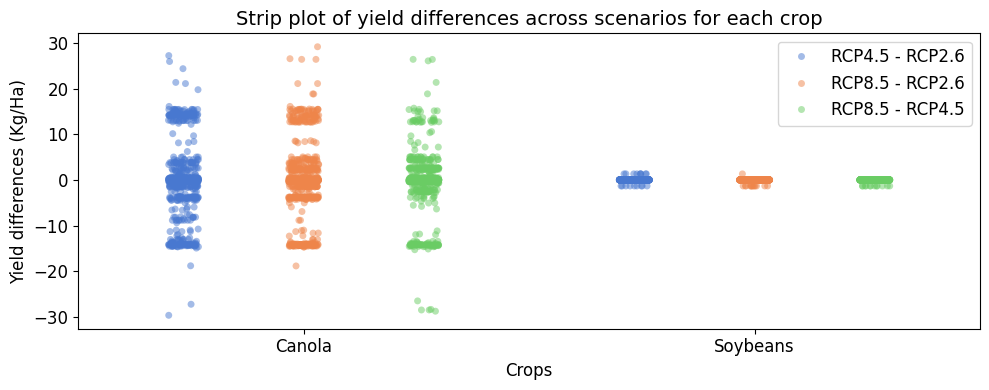

In [ ]:
# Plotting the strip plot for yield differences
crops = ['Canola', 'Soybeans']
data = {}
for crop in crops:
    data[crop] = pd.read_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_{crop}.csv')

# Computing the differences
for crop in crops:
    data[crop]['Diff_4.5_2.6'] = data[crop]['Crop_yield_RCP45'] - data[crop]['Crop_yield_RCP26']
    data[crop]['Diff_8.5_2.6'] = data[crop]['Crop_yield_RCP85'] - data[crop]['Crop_yield_RCP26']
    data[crop]['Diff_8.5_4.5'] = data[crop]['Crop_yield_RCP85'] - data[crop]['Crop_yield_RCP45']

# Combining data into a single DataFrame with a new column for the scenario differences
combined_df = pd.concat([data[crop].assign(Crop=crop) for crop in crops])
combined_df_melted = combined_df.melt(id_vars=['Crop'], value_vars=['Diff_4.5_2.6', 'Diff_8.5_2.6', 'Diff_8.5_4.5'], var_name='Scenario', value_name='Yield Difference')

# Mapping scenario names to more readable format
scenario_labels = {
    'Diff_4.5_2.6': 'RCP4.5 - RCP2.6',
    'Diff_8.5_2.6': 'RCP8.5 - RCP2.6',
    'Diff_8.5_4.5': 'RCP8.5 - RCP4.5'
}
combined_df_melted['Scenario'] = combined_df_melted['Scenario'].map(scenario_labels)

plt.figure(figsize=(10, 4))

# Plotting the strip plot
sns.stripplot(data=combined_df_melted, x='Crop', y='Yield Difference', hue='Scenario', palette='muted', dodge=True, jitter=True, alpha=0.5)

plt.title('Strip plot of yield differences across scenarios for each crop', fontsize=14)
plt.xlabel('Crops', fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Yield differences (Kg/Ha)', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Calculating absolute mean yield difference for each crop and scenario
combined_df_melted['Abs_Yield_Difference'] = combined_df_melted['Yield Difference'].abs()
abs_mean_yield_diff = combined_df_melted.groupby(['Crop', 'Scenario'])['Abs_Yield_Difference'].mean().reset_index()
abs_mean_yield_diff.columns = ['Crop', 'Scenario', 'Absolute mean yield difference']
print(abs_mean_yield_diff)

       Crop         Scenario  Absolute mean yield difference
0    Canola  RCP4.5 - RCP2.6                        4.451685
1    Canola  RCP8.5 - RCP2.6                        4.621043
2    Canola  RCP8.5 - RCP4.5                        2.772219
3  Soybeans  RCP4.5 - RCP2.6                        0.030349
4  Soybeans  RCP8.5 - RCP2.6                        0.023967
5  Soybeans  RCP8.5 - RCP4.5                        0.020969


# Calculating yield differences between 2021 and 2026

In [ ]:
# Predicting crop yields for the year 2021 at the CCS level
All_variables_2021_CCS = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/All_variables_prepared_2021_CCS.xlsx')
All_variables_2021_CCS_sorted = All_variables_2021_CCS.sort_values(by=['New_ID', 'Months']).reset_index(drop=True)

ID_df = pd.DataFrame(All_variables_2021_CCS_sorted['New_ID'].unique())
ID_df.columns = ['New_ID']

Crops = ['Canola', 'Soybeans']

for crop in Crops:
  if crop == 'Canola':
    X_training = X_Canola_train
    Y_training = Y_Canola_train
    optimized_n_estimators = 500
    optimized_max_depth = 5
  elif crop == 'Soybeans':
    X_training = X_Soybeans_train
    Y_training = Y_Soybeans_train
    optimized_n_estimators = 100
    optimized_max_depth = 9

  X_test_CCS = All_variables_2021_CCS_sorted.drop(columns = ['New_ID'], axis=1)

  # Using the model with the highest accuracy (i.e., XGBoost) to predict the crop yields at the CCS level
  XGBoost = xgb.XGBRegressor(n_estimators=optimized_n_estimators, max_depth = optimized_max_depth, random_state=42)
  XGBoost.fit(X_training, Y_training)
  Y_pred_XGBoost_CCS = XGBoost.predict(X_test_CCS)

  Y_pred_XGBoost_CCS[Y_pred_XGBoost_CCS < 0] = 0

  Y_pred_XGBoost_df = pd.DataFrame(Y_pred_XGBoost_CCS, columns = ['Crop_yield_Predicted'])

  # Splitting dataframe into groups of five rows
  groups = np.arange(len(Y_pred_XGBoost_df)) // 5  # This creates groups of 5 rows each and is the same for all predicted arrays

  # Calculating the mean of crop yields
  Mean_Y_pred = Y_pred_XGBoost_df.groupby(groups).mean()


  # Saving the results in Google Drive
  pd.concat([ID_df, Mean_Y_pred], axis=1).to_csv(f'/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Mean_Y_pred_{crop}_CCS.csv')

In [ ]:
# Loading predicted crop yields for the years 2021 and 2026
# Year 2021
Canola_2021 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Mean_Y_pred_Canola_CCS.csv')
Soybeans_2021 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2021/Mean_Y_pred_Soybeans_CCS.csv')
# Year 2026
Canola_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Canola.csv')
Soybeans_2026 = pd.read_csv('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Mean_Y_pred_all_scenarios_Soybeans.csv')

In [ ]:
# Identifying the CCS_ID in each province
Prov_CCS_ID = pd.read_excel('/content/drive/My Drive/Excel_files_Crop_yield_prediction_2026/Provinces_CCS_ID.xlsx')
Prov_CCS_ID.replace('<Null>', np.nan, inplace=True)
# Filtering rows in Prov_CCS_ID where 'New_ID' is in ID_df
Provinces_CCS_ID_BC = Prov_CCS_ID[Prov_CCS_ID['BC'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_AB = Prov_CCS_ID[Prov_CCS_ID['AB'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_MB = Prov_CCS_ID[Prov_CCS_ID['MB'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_SK = Prov_CCS_ID[Prov_CCS_ID['SK'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_ON = Prov_CCS_ID[Prov_CCS_ID['ON'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_QC = Prov_CCS_ID[Prov_CCS_ID['QC'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_NB = Prov_CCS_ID[Prov_CCS_ID['NB'].isin(ID_df['New_ID'])]
Provinces_CCS_ID_NS = Prov_CCS_ID[Prov_CCS_ID['NS'].isin(ID_df['New_ID'])]

# Identifying the CCS_ID in each province
# BC
New_ID_BC_unique = Provinces_CCS_ID_BC['BC'].unique()
New_ID_BC = New_ID_BC_unique[~np.isnan(New_ID_BC_unique)]

# AB
New_ID_AB_unique = Provinces_CCS_ID_AB['AB'].unique()
New_ID_AB = New_ID_AB_unique[~np.isnan(New_ID_AB_unique)]

# MB
New_ID_MB_unique = Provinces_CCS_ID_MB['MB'].unique()
New_ID_MB = New_ID_MB_unique[~np.isnan(New_ID_MB_unique)]

# SK
New_ID_SK_unique = Provinces_CCS_ID_SK['SK'].unique()
New_ID_SK = New_ID_SK_unique[~np.isnan(New_ID_SK_unique)]

# ON
New_ID_ON_unique = Provinces_CCS_ID_ON['ON'].unique()
New_ID_ON = New_ID_ON_unique[~np.isnan(New_ID_ON_unique)]

# QC
New_ID_QC_unique = Provinces_CCS_ID_QC['QC'].unique()
New_ID_QC = New_ID_QC_unique[~np.isnan(New_ID_QC_unique)]

# NB
New_ID_NB_unique = Provinces_CCS_ID_NB['NB'].unique()
New_ID_NB = New_ID_NB_unique[~np.isnan(New_ID_NB_unique)]

# NS
New_ID_NS_unique = Provinces_CCS_ID_NS['NS'].unique()
New_ID_NS = New_ID_NS_unique[~np.isnan(New_ID_NS_unique)]

In [ ]:
# Calculating the yield differences between the years 2021 and 2026 for each province
provinces = ['BC', 'AB', 'MB', 'SK', 'ON', 'QC', 'NB', 'NS']

total_diff_yield = {
    'Canola': {province: 0 for province in provinces},
    'Soybeans': {province: 0 for province in provinces},
}

for province in provinces:
  New_IDs = globals()[f'New_ID_{province}']

  # Calculating yield differences for each crop in the current province
  for ind in New_IDs:
    # Canola
    canola_diff_yield_each_CCS = Canola_2026[Canola_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - Canola_2021[Canola_2021['New_ID'] == ind]['Crop_yield_Predicted'].values[0]
    total_diff_yield['Canola'][province] += canola_diff_yield_each_CCS

    # Soybeans
    soybeans_diff_yield_each_CCS = Soybeans_2026[Soybeans_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0] - Soybeans_2021[Soybeans_2021['New_ID'] == ind]['Crop_yield_Predicted'].values[0]
    total_diff_yield['Soybeans'][province] += soybeans_diff_yield_each_CCS

# Printing the total yield differences for each crop in each province
for crop in total_diff_yield:
  for province in total_diff_yield[crop]:
    print(f'Total {crop.lower()} yield difference for {province}: {np.ceil(total_diff_yield[crop][province])}')
  print('_ '*30)

Total canola yield difference for BC: -681.0
Total canola yield difference for AB: -296.0
Total canola yield difference for MB: -184.0
Total canola yield difference for SK: -1696.0
Total canola yield difference for ON: -431.0
Total canola yield difference for QC: 232.0
Total canola yield difference for NB: 359.0
Total canola yield difference for NS: 250.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total soybeans yield difference for BC: -4135.0
Total soybeans yield difference for AB: -3334.0
Total soybeans yield difference for MB: -349.0
Total soybeans yield difference for SK: -8863.0
Total soybeans yield difference for ON: 413.0
Total soybeans yield difference for QC: 48.0
Total soybeans yield difference for NB: 4.0
Total soybeans yield difference for NS: 2.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [ ]:
# Calculating the yields for the year 2021 for each province
provinces = ['BC', 'AB', 'MB', 'SK', 'ON', 'QC', 'NB', 'NS']

total_yield = {
    'Canola': {province: 0 for province in provinces},
    'Soybeans': {province: 0 for province in provinces},
}

for province in provinces:
  New_IDs = globals()[f'New_ID_{province}']

  # Calculating yields for each crop in the current province
  for ind in New_IDs:
    # Canola
    canola_yield_each_CCS = Canola_2021[Canola_2021['New_ID'] == ind]['Crop_yield_Predicted'].values[0]
    total_yield['Canola'][province] += canola_yield_each_CCS

    # Soybeans
    soybeans_yield_each_CCS = Soybeans_2021[Soybeans_2021['New_ID'] == ind]['Crop_yield_Predicted'].values[0]
    total_yield['Soybeans'][province] += soybeans_yield_each_CCS

# Printing the total differences for each crop in each province
for crop in total_yield:
  for province in total_yield[crop]:
    print(f'Total {crop.lower()} yields for {province} is: {np.ceil(total_yield[crop][province])}')
  print('_ '*30)

Total canola yields for BC is: 44181.0
Total canola yields for AB is: 17886.0
Total canola yields for MB is: 26177.0
Total canola yields for SK is: 99549.0
Total canola yields for ON is: 123656.0
Total canola yields for QC is: 68058.0
Total canola yields for NB is: 8459.0
Total canola yields for NS is: 4719.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total soybeans yields for BC is: 47378.0
Total soybeans yields for AB is: 23172.0
Total soybeans yields for MB is: 28133.0
Total soybeans yields for SK is: 95107.0
Total soybeans yields for ON is: 163008.0
Total soybeans yields for QC is: 62240.0
Total soybeans yields for NB is: 4555.0
Total soybeans yields for NS is: 2855.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [ ]:
# Calculating the yields for the year 2026 under the scenario RCP 8.5 for each province
provinces = ['BC', 'AB', 'MB', 'SK', 'ON', 'QC', 'NB', 'NS']

total_yield = {
    'Canola': {province: 0 for province in provinces},
    'Soybeans': {province: 0 for province in provinces},
}

for province in provinces:
  New_IDs = globals()[f'New_ID_{province}']

  # Calculating yields for each crop in the current province
  for ind in New_IDs:
    # Canola
    canola_yield_each_CCS = Canola_2026[Canola_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Canola'][province] += canola_yield_each_CCS

    # Soybeans
    soybeans_yield_each_CCS = Soybeans_2026[Soybeans_2026['New_ID'] == ind]['Crop_yield_RCP85'].values[0]
    total_yield['Soybeans'][province] += soybeans_yield_each_CCS

# Printing the total differences for each crop in each province
for crop in total_yield:
  for province in total_yield[crop]:
    print(f'Total {crop.lower()} yields for {province} is: {np.ceil(total_yield[crop][province])}')
  print('_ '*30)

Total canola yields for BC is: 43499.0
Total canola yields for AB is: 17590.0
Total canola yields for MB is: 25993.0
Total canola yields for SK is: 97853.0
Total canola yields for ON is: 123225.0
Total canola yields for QC is: 68290.0
Total canola yields for NB is: 8818.0
Total canola yields for NS is: 4968.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Total soybeans yields for BC is: 43242.0
Total soybeans yields for AB is: 19837.0
Total soybeans yields for MB is: 27783.0
Total soybeans yields for SK is: 86244.0
Total soybeans yields for ON is: 163420.0
Total soybeans yields for QC is: 62288.0
Total soybeans yields for NB is: 4559.0
Total soybeans yields for NS is: 2856.0
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


#Assessing the importance of variables on yields for each crop type

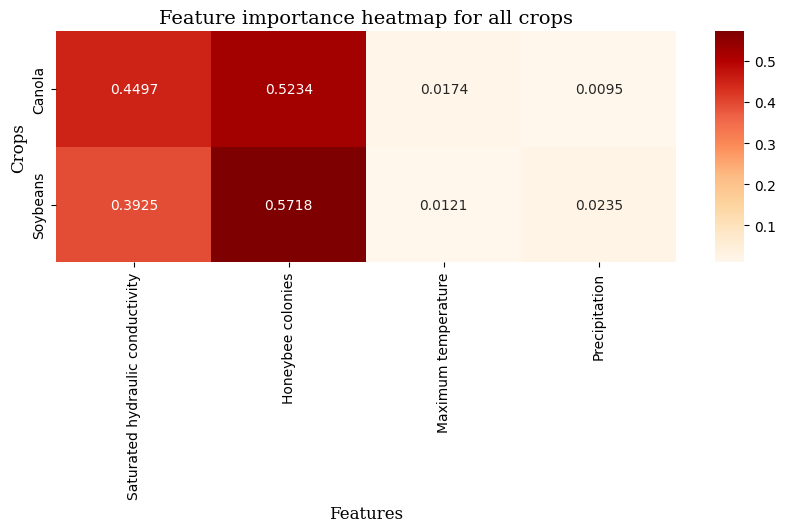

In [ ]:
# Initialize a DataFrame to store all feature importances
all_importances = pd.DataFrame()

Crops = ['Canola', 'Soybeans']

for crop in Crops:
  if crop == 'Canola':
    X_training = X_Canola_train
    Y_training = Y_Canola_train
    optimized_n_estimators = 500
    optimized_max_depth = 5
  elif crop == 'Soybeans':
    X_training = X_Soybeans_train
    Y_training = Y_Soybeans_train
    optimized_n_estimators = 100
    optimized_max_depth = 9

  # XGBoost
  XGBoost = xgb.XGBRegressor(n_estimators=optimized_n_estimators, max_depth = optimized_max_depth, random_state=42)
  XGBoost.fit(X_training, Y_training)

  # Getting feature importances
  importances = XGBoost.feature_importances_

  # Normalizing the importances to sum to 1
  importances = importances / importances.sum()

  # Creating a DataFrame for visualization
  importance_df = pd.DataFrame({
      'feature': Considered_variables_2021.drop(columns=['CARUID','Canola', 'Soybeans'], axis=1).columns,
      crop: importances
  })

  # Appending the importances to the all_importances DataFrame
  if all_importances.empty:
    all_importances = importance_df
  else:
    all_importances = all_importances.merge(importance_df, on='feature')

# Setting feature as the index
all_importances.set_index('feature', inplace=True)

# Transposing the DataFrame for heatmap
importance_pivot = all_importances.T

# Plotting the heatmap using Seaborn library
plt.figure(figsize=(10, 3))
sns.heatmap(importance_pivot, annot=True, fmt='.4f', cmap='OrRd', cbar_kws={'aspect': 8})
plt.title('Feature importance heatmap for all crops', fontdict={'family': 'serif', 'weight': 'normal', 'size': 14})
plt.xlabel('Features', fontdict={'family': 'serif', 'weight': 'normal', 'size': 12})
plt.ylabel('Crops', fontdict={'family': 'serif', 'weight': 'normal', 'size': 12})
plt.xticks(rotation=90)
plt.show()